<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-477 Redes Neuronales Artificiales I-2018 </h1>

<H3 align='center'> Tarea 2 - Pregunta 1 - Redes Convolucionales y sus aplicaciones </H3>
<H3 align='center'>  Jorge Portilla - John Rodriguez </H3>

<hr style="height:2px;border:none"/>

# Convolutional Neural Networks (CNN) en CIFAR

Se trabajará con el dataset CIFAR10, que esta compuesto por un conjunto de 60.000 imágenes RGB de 32 × 32 pixeles que contiene 10 clases de objetos y **6000 ejemplos por clase**. La versión utilizada se le atribuye a *A. Krizhevsky, V. Nair* y *G. Hinton* y viene separada en **50000 ejemplos de entrenamiento** y **10000 casos de prueba** que fueron obtenidos seleccionando 1000 imágenes aleatorias de cada clase.

Los datos restantes han sido ordenados aleatoriamente y están organizados en **5 bloques de entrenamiento o batches**. Cabe destacar que las clases son mutuamente excluyentes y corresponden a las siguientes categorı́as: 

* Gato
* Perro
* Rana
* Caballo
* Pájaro
* Ciervo
* Avión
* Automóvil
* Camión 
* Barco

Para esta tarea se experimentará con redes convolucionales, conocidas como CNNs.


In [0]:
#Librerías y modulos
import cv2 
import numpy as np   
import os   
from keras.datasets import cifar10
import keras
import pandas as pd
import matplotlib.pyplot as plt
import math
import itertools
from google.colab import files

In [0]:
#!pip uninstall opencv-python
#!pip install opencv-python==3.1.0.4 opencv-contrib-python==3.4.2.16
cv2.__version__

'3.4.3'

In [0]:
def plotCurves(curves, labels, title, legends):
    plt.figure(1, figsize=(10, 6))
    for C in curves:
        plt.plot(range(1, len(C)+1), C)
    plt.ylabel(labels[1])
    plt.xlabel(labels[0])
    plt.title(title)
    plt.grid(True)
    plt.legend(legends)
    plt.show()

Se crea la clase **TestCallback** para poder guardar el error y la precisión al evaluar el modelo en el conjunto de testing en cada una de las epochs, no solo al final.

In [0]:
class TestCallback(keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        test_loss.append(loss)
        test_acc.append(acc)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))

In [27]:
uploaded = files.upload()

Saving histories_1g_deep.csv to histories_1g_deep (1).csv




---



## Pregunta A

> Construya una función que cargue todos los bloques de entrenamiento y pruebas del problema CIFAR generando como salida:
+ dos matrices  Xtr, Ytr; correspondientes a las imágenes y etiquetas de entrenamiento,
+ dos matrices Xt, Yt; correspondientes a las imágenes y etiquetas de pruebas,
+ dos matrices Xv, Yv; correspondientes a las imágenes y etiquetas que se usarán como conjunto de validación (para tomar decisiones de diseño acerca del modelo).
**Este último conjunto debe ser extraı́do desde el conjunto de entrenamiento original y no debe superar las 5000 imágenes.**

La función loadCifar10 crea los conjuntos de training, validación y testing, donde se tiene 90% de training y 10% de validación, para no superar las 5000 imágenes de validación.

In [0]:
def loadCifar10():
    label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    #60% of the data for training, 40% for validation
    x_train, x_val = np.vsplit(x_train, [int(0.9*x_train.shape[0])])
    y_train, y_val = np.vsplit(y_train, [int(0.9*y_train.shape[0])])
    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

Por medio de la función loadCifar10(), descargamos los datos para los bloques de entranamiento, pruebas y test.

In [0]:
(x_train, y_train), (x_val, y_val), (x_test, y_test) = loadCifar10()

170500096/170498071 [==============================] - 15s 0us/step


Se confirma el número de imagenes en el conjunto de validación:

In [0]:
y_val.shape

(5000, 1)



---



## Pregunta B

> Prepare subconjuntos de entrenamiento, validación y pruebas normalizando las imágenes de entrenamiento y pruebas, dividiendo las intensidades originales de pixel en cada canal por 255.  Es importante notar que si desea trabajar con el orden de las dimensiones denominado ’tf’ (por defecto para TensorFlow) deberá realizar la transposición correspondiente para dejar el canal en donde corresponda. Finalmente, genere una representación adecuada de las salidas deseadas de la red.

Se normaliza cada uno de los conjuntos de características, dividiendolos por 255, y categorizamos los conjuntos target.

In [0]:
x_train = x_train / 255
x_val = x_val / 255
x_test = x_test / 255

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)
y_val = keras.utils.to_categorical(y_val, 10)



---


## Pregunta C

> Defina una CNN con arquitectura $C \times P \times C \times P \times F \times F$. Para ambas capas convolucionales utilice 64 filtros de $3 \times 3$ y funciones de activación ReLU. Para las capas de pooling utilice filtros de $2 \times 2$ con stride 2. Para la capa MLP escondida use 512 neuronas. Genere un esquema lo más compacto posible que muestre los cambios de forma (dimensionalidad) que experimenta un patrón de entrada a medida que se ejecuta un forward-pass y el número de parámetros de cada capa.

Se crea un modelo *Sequential* usando keras, añadiendole las diferentes capas que se mencionan. Luego, se muestra una tabla la cual muestra las características de las capas, su dimensiones y sus parámetros.

In [0]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, (3, 3), padding='same', input_shape = x_train.shape[1:]))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), padding='same'))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dense(10))
model.add(keras.layers.Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_37 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
activation_38 (Activation)   (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 4096)              0         
__________

Se define una CNN con arquitectura $C \times P \times C \times P \times F \times F$. En las capas convolucionales se utilizan 64 filtros de $3 \times 3$ 
Después de cada capa convolucional es recomendable aplicar una capa no lineal, con el propósito de añadir no linealidad a un proceso que ejecuta operaciones lineales durante las capas convolucionales. En este caso usar ReLu hace el entrenamiento más rápido al ser computacionalmete eficiente, ademas de ayudar a prevenir el desvanecimiento del gradiente. Las capas de pooling con filtros de 2x2 que extraen en valor máximo de cada región, en esta capa no hay parámetros para aprender solo se utiliza para disminuir la dimensionalidad. Utilizando stride igual a 2 que significa que el filtro se desplaza en dos unidades.
La capa Flatten cumple la función de ubicar en un solo vector continuo largo las matrices bidimensionales generadas en las capas anteriores para que sean la entrada a la capa MLP escondida de 512 neuronas.

A continuación se realiza una descripción detallada de los parámetros a entrenar para cada capa:

   Fórmula (n x m x L + 1) x k
   * n, m :tamaño del filtro
   * L : dimensiones de entrada, 1 por el bias
   * K : features maps de salida.

1.   Layer0, toma 32 feature maps de entrada y tiene 64 feature maps de salida.  **(3x3x3 + 1) x 64 = 1792 parámetros**
2.   Layer3,    **(3 x 3 x 64 + 1) x 64 = 36.928 parámetros**
3.  (p+1) x r, donde p es la dimensionalidad de entrada y r la dimensionalidad de salida.  **(4096+1)x 512= 2097664**,  4096 es la salida producida por la capa de flatten que representa la información en un solo vector largo.
4.  **( 512+1) x 10 = 5130**

**En total se deben entrenar 1.090.122 de parámetros en este modelo.**



---


## Pregunta D

>  Entrene la CNN definida en **c)** utilizando SGD. En este dataset, una tasa de aprendizaje “segura” es $\eta = 10^{-4}$ o inferior, pero durante las primeras *epochs* el entrenamiento resulta demasiado lento. Para resolver el problema aprenderemos a controlar la tasa de aprendizaje utilizada en el entrenamiento. Implemente la siguiente idea: deseamos partir con una tasa de aprendizaje $\eta = 10^{-3}$ y dividir por 2 ese valor cada 10 epochs. Suponga además que no queremos usar una tasa de aprendizaje menor a $\eta = 10^{-5}$.  Construya un gráfico que muestre los errores de entrenamiento, validación y pruebas como función del número de “epochs”, entrene con 25 *epochs*.

Se crea la función **step_decay**, la cual determinará el learning rate en cada una de las epochs siguiendo la idea de comenzar con un learning rate más pequeño y luego ir aumentandolo.

In [0]:
def step_decay(epoch):
    initial_lrate = 0.001
    lrate = initial_lrate * math.pow(0.5, math.floor((1+epoch)/5))
    lrate = max(lrate,0.00001)
    return lrate

Se procede a realizar el experimento usando el modelo creado en **c)**. Se compila el modelo usando como optimizador un SGD, se usa categorical crossentropy para el error y además medimos la precisión del modelo.

In [0]:
test_loss = []
test_acc = []
opt = keras.optimizers.SGD(lr=0.0, momentum=0.9, decay=0.0)
lrate = keras.callbacks.LearningRateScheduler(step_decay)
model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=['accuracy'])
history_1d = model.fit(x_train, y_train,batch_size = 32, epochs = 25, validation_data=(x_val,y_val), shuffle=True, callbacks=[TestCallback((x_test, y_test)),lrate])
history_1d.history["test_loss"] = test_loss
history_1d.history["test_acc"] = test_acc
result = pd.DataFrame(history_1d.history)
result.to_csv("history_1d.csv")

Train on 45000 samples, validate on 5000 samples
Epoch 1/25
45000/45000 [==============================] - 17s 386us/step - loss: 1.9395 - acc: 0.3026 - val_loss: 1.7022 - val_acc: 0.3896

Testing loss: 1.6847313283920289, acc: 0.4033

Epoch 2/25
45000/45000 [==============================] - 17s 377us/step - loss: 1.5560 - acc: 0.4449 - val_loss: 1.4497 - val_acc: 0.4846

Testing loss: 1.4414213457107543, acc: 0.4831

Epoch 3/25
45000/45000 [==============================] - 17s 375us/step - loss: 1.3796 - acc: 0.5110 - val_loss: 1.2991 - val_acc: 0.5364

Testing loss: 1.3029361904144288, acc: 0.535

Epoch 4/25
45000/45000 [==============================] - 18s 396us/step - loss: 1.2642 - acc: 0.5535 - val_loss: 1.2411 - val_acc: 0.5556

Testing loss: 1.242612928199768, acc: 0.5544

Epoch 5/25
45000/45000 [==============================] - 17s 375us/step - loss: 1.1589 - acc: 0.5933 - val_loss: 1.1656 - val_acc: 0.5884

Testing loss: 1.1670282934188843, acc: 0.5859

Epoch 6/25
45000/4

Se gráfican las curvas de error del entrenamiento, validación y testing en función del número de epochs

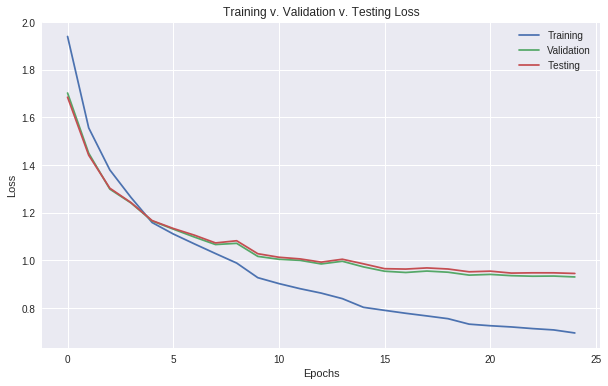

In [0]:
history_1d = pd.read_csv("history_1d.csv")
plotCurves([history_1d['loss'], history_1d['val_loss'], history_1d['test_loss']], ['Epochs', 'Loss'], 'Training v. Validation v. Testing Loss', ['Training', 'Validation','Testing'])

In [0]:
files.download('history_1d.csv') # from colab to browser download

Se puede notar que gracias a la modificación del learning rate los tiempos de espera en un inicio son menores comparados con otros entrenamientos. El error en el conjunto de entrenamiento es menor que el error en el conjunto de validación y testing, siendo estos últimos muy parecidos. Esto último puede ser causado gracias a que el conjunto de validación podría ser una **buena representación** del conjunto de testing.



---


## Pregunta E

> Entrene la CNN definida en c) utilizando **RMSProp** durante 25 *epochs*. Elija la función de pérdida más apropiada para este problema. Construya finalmente un gráfico que muestre los errores de entrenamiento, validación y pruebas como función del número de *epochs*.
*Hint: La curva sugiere algún cambio en el modelo definido, considere ésto en cuenta para las experimentaciones futuras.*



Primero, se crea el modelo de la misma manera que en **c)** y se compila usando el optimizador RMSProp y se entrena el modelo.

In [0]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, (3, 3), padding='same', input_shape = x_train.shape[1:]))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), padding='same'))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dense(10))
model.add(keras.layers.Activation('softmax'))

test_loss = []
test_acc = []
opt = keras.optimizers.rmsprop(lr=0.001, decay=1e-6)
model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=['accuracy'])
history_1e = model.fit(x_train, y_train, batch_size= 128, epochs = 25, validation_data=(x_val, y_val), shuffle=True, callbacks=[TestCallback((x_test, y_test))])
history_1e.history["test_loss"] = test_loss
history_1e.history["test_acc"] = test_acc
result_1e = pd.DataFrame(history_1e.history)
result_1e.to_csv("history_1e.csv")

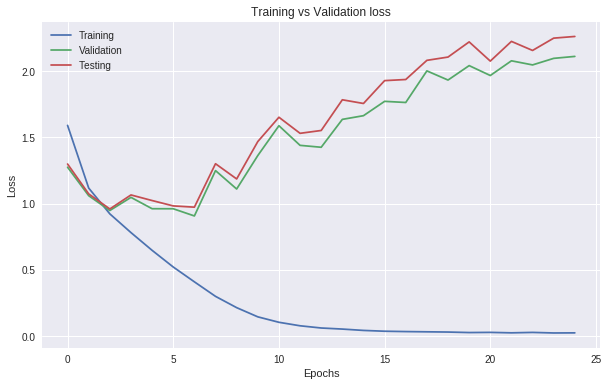

In [0]:
history_1e = pd.read_csv("history_1e.csv")
plotCurves([history_1e['loss'], history_1e['val_loss'], history_1e['test_loss']], ['Epochs', 'Loss'], 'Training vs Validation loss', ['Training', 'Validation','Testing'])

Analizando el gráfico, se puede indicar que se produce **overfitting**, es decir, el modelo aprende muy bien el conjunto de entrenamiento, pero le cuesta predecir generalizaciones, como se puede apreciar al ver como el error diverge en la validación y el testing.

Para disminuir el overfitting se utilizaran regularizadores l2 en cada una de las capas de convolución y una capa de Drouput luego de cada capa de Pooling.

In [0]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, (3, 3), padding='same', input_shape = x_train.shape[1:], kernel_regularizer = keras.regularizers.l2(0.1)))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer = keras.regularizers.l2(0.1)))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dense(10))
model.add(keras.layers.Activation('softmax'))

test_loss = []
test_acc = []
opt = keras.optimizers.rmsprop(lr=0.001, decay=1e-6)
model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=['accuracy'])
history_1e_alt = model.fit(x_train, y_train, batch_size= 128, epochs = 25, validation_data=(x_val, y_val), shuffle=True, callbacks=[TestCallback((x_test, y_test))])
history_1e_alt.history["test_loss"] = test_loss
history_1e_alt.history["test_acc"] = test_acc
result_1e_alt = pd.DataFrame(history_1e_alt.history)
result_1e_alt.to_csv("history_1e_alt5.csv")

Train on 45000 samples, validate on 5000 samples
Epoch 1/25
45000/45000 [==============================] - 9s 206us/step - loss: 2.4221 - acc: 0.3371 - val_loss: 1.7633 - val_acc: 0.4208

Testing loss: 1.7635954702377319, acc: 0.4182

Epoch 2/25
45000/45000 [==============================] - 8s 188us/step - loss: 1.7289 - acc: 0.4380 - val_loss: 1.9253 - val_acc: 0.3854

Testing loss: 1.925219355583191, acc: 0.3815

Epoch 3/25
45000/45000 [==============================] - 9s 205us/step - loss: 1.6260 - acc: 0.4642 - val_loss: 1.8160 - val_acc: 0.4032

Testing loss: 1.8325186725616456, acc: 0.4023

Epoch 4/25
45000/45000 [==============================] - 15s 325us/step - loss: 1.5533 - acc: 0.4907 - val_loss: 1.5424 - val_acc: 0.4888

Testing loss: 1.5496356407165528, acc: 0.4828

Epoch 5/25
45000/45000 [==============================] - 15s 327us/step - loss: 1.4982 - acc: 0.5106 - val_loss: 1.4866 - val_acc: 0.5110

Testing loss: 1.4845140699386596, acc: 0.5119

Epoch 6/25
45000/450

Se gráfica las los resultados de entrenamiento, validación y pruebas. Se ve la mejora en la capacidad de generalizar del algoritmo añadiendo Dropout y relularizadores l2.

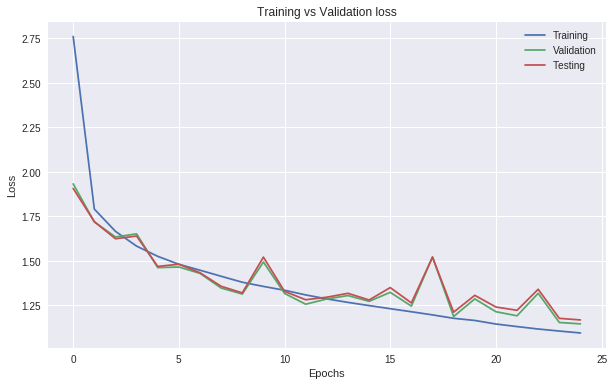

In [0]:
history_1e_alt = pd.read_csv("history_1e_alt5.csv")
plotCurves([history_1e_alt['loss'], history_1e_alt['val_loss'], history_1e_alt['test_loss']], ['Epochs', 'Loss'], 'Training vs Validation loss', ['Training', 'Validation','Testing'])

Gracias a la adición de regularizadores como l2 y Dropout el error en el conjunto de testing y validación disminuye por cada epoch, es decir, converge. Esto se debe a que con dropout solo se "prenden" ciertas neuronas de cada capa, y con l2 llevamos ciertos pesos a casi cero, haciendo que la red sea más estable.



---


## Pregunta F

> Evalúe el efecto de modificar el tamaño de los filtros (de convolución) reportando la sensibilidad del error de pruebas a estos cambios en dos tipos de arquitecturas, una profunda y otra no. Presente un gráfico o tabla resumen. Por simplicidad entre durante sólo 15-20 *epochs*.


### **Red con arquitectura Shallow**
Primero veremos el efecto de modificar el tamaño de los filtros en una red shallow. Esta contará con una capa convolucional con 64 feature maps, donde los filtros tendrán tamaño 2, 3, 6 y 9. Luego se usa una capa pooling con filtro de tamaño 2, seguida de una capa de 512 neuronas con función de activación relu, para finalmente terminar con la capa final con 10 neuronas con función de activación softmax.

In [0]:
histories = dict()
for nc in [9, 6, 3, 2]:
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(64, (nc, nc), padding='same', input_shape=x_train.shape[1:]))
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(512))
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.Dense(10))
    model.add(keras.layers.Activation('softmax'))
    test_loss = []
    test_acc = []
    opt = keras.optimizers.SGD(lr=0.0, momentum=0.9, decay=0.0)
    lrate = keras.callbacks.LearningRateScheduler(step_decay)
    model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, batch_size= 32, epochs = 15, validation_data=(x_val, y_val), shuffle=True, callbacks=[TestCallback((x_test, y_test)), lrate])
    history.history["test_loss"] = test_loss
    history.history["test_acc"] = test_acc
    histories[nc] = pd.DataFrame(history.history)

result = pd.concat(histories)
result.to_csv("history_1f_shallow.csv")

Train on 45000 samples, validate on 5000 samples
Epoch 1/15
45000/45000 [==============================] - 22s 478us/step - loss: 1.7751 - acc: 0.3686 - val_loss: 1.5618 - val_acc: 0.4360

Testing loss: 1.5436371753692626, acc: 0.4505

Epoch 2/15
45000/45000 [==============================] - 17s 387us/step - loss: 1.4427 - acc: 0.4877 - val_loss: 1.3837 - val_acc: 0.5028

Testing loss: 1.3800277883529664, acc: 0.5041

Epoch 3/15
45000/45000 [==============================] - 17s 386us/step - loss: 1.3189 - acc: 0.5352 - val_loss: 1.2984 - val_acc: 0.5480

Testing loss: 1.300721968269348, acc: 0.5403

Epoch 4/15
45000/45000 [==============================] - 17s 386us/step - loss: 1.2199 - acc: 0.5711 - val_loss: 1.2183 - val_acc: 0.5634

Testing loss: 1.234398298072815, acc: 0.5567

Epoch 5/15
45000/45000 [==============================] - 17s 386us/step - loss: 1.1035 - acc: 0.6145 - val_loss: 1.1271 - val_acc: 0.6060

Testing loss: 1.1421826189041138, acc: 0.5939

Epoch 6/15
45000/4

Graficamos los 4 casos modelados para los errores de entrenamiento, validación y testing.

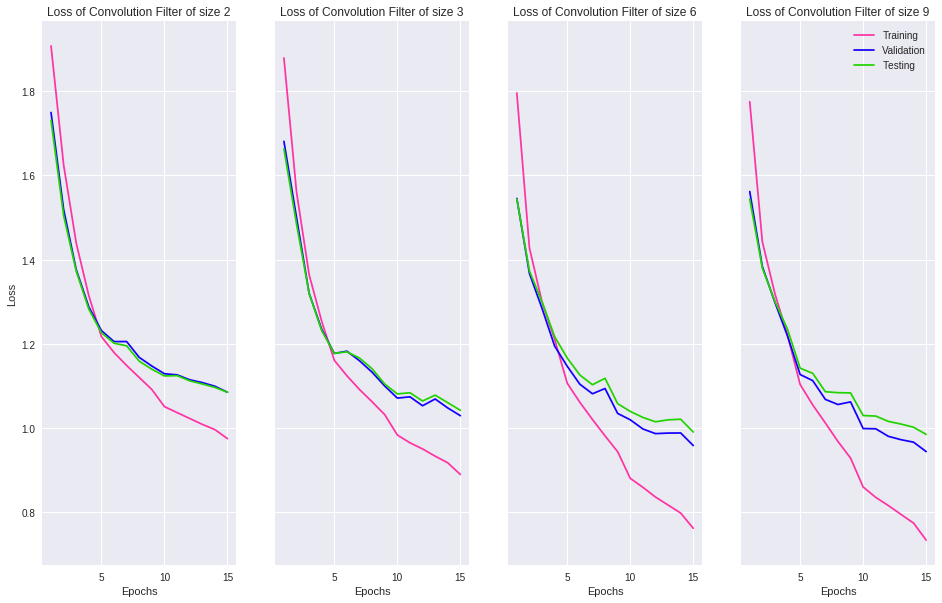

In [0]:
histories_1f = pd.read_csv("history_1f_shallow.csv", dtype={'Unnamed: 0':int,'Unnamed: 1':int,'val_loss':float,
                                                    'loss': float}, index_col=[0,1], skipinitialspace=True)

nc = [2, 3, 6, 9]
f, axes = plt.subplots(1, 4, sharey=True, figsize=(16, 10))
axes[0].set_ylabel("Loss")
for i in range(len(nc)):
    axes[i].plot(range(1, 16), histories_1f['loss'][nc[i]], '#ff33a3', label = "Training")
    axes[i].plot(range(1, 16), histories_1f['val_loss'][nc[i]], '#1300FF', label = "Validation")
    axes[i].plot(range(1, 16), histories_1f['test_loss'][nc[i]], '#23D300', label = "Testing")
    axes[i].grid(True)
    axes[i].set_title("Loss of Convolution Filter of size "+str(nc[i]))
    axes[i].set_xlabel("Epochs")
axes[-1].legend()
plt.show()

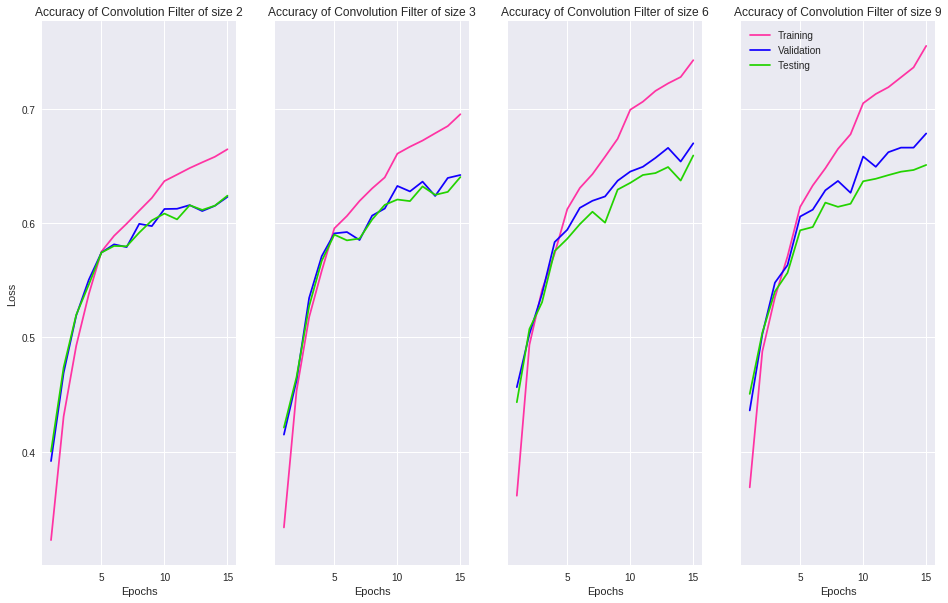

In [0]:
histories_1f = pd.read_csv("history_1f_shallow.csv", dtype={'Unnamed: 0':int,'Unnamed: 1':int,'val_loss':float,
                                                    'loss': float}, index_col=[0,1], skipinitialspace=True)

nc = [2, 3, 6, 9]
f, axes = plt.subplots(1, 4, sharey=True, figsize=(16, 10))
axes[0].set_ylabel("Loss")
for i in range(len(nc)):
    axes[i].plot(range(1, 16), histories_1f['acc'][nc[i]], '#ff33a3', label = "Training")
    axes[i].plot(range(1, 16), histories_1f['val_acc'][nc[i]], '#1300FF', label = "Validation")
    axes[i].plot(range(1, 16), histories_1f['test_acc'][nc[i]], '#23D300', label = "Testing")
    axes[i].grid(True)
    axes[i].set_title("Accuracy of Convolution Filter of size "+str(nc[i]))
    axes[i].set_xlabel("Epochs")
axes[-1].legend()
plt.show()

A continuación se muestran gráficos para comparar el error de entrenamiento, validación y pruebas. Con esto poder comparar el efecto que tiene el cambio del tamaño del filtro convolucional.

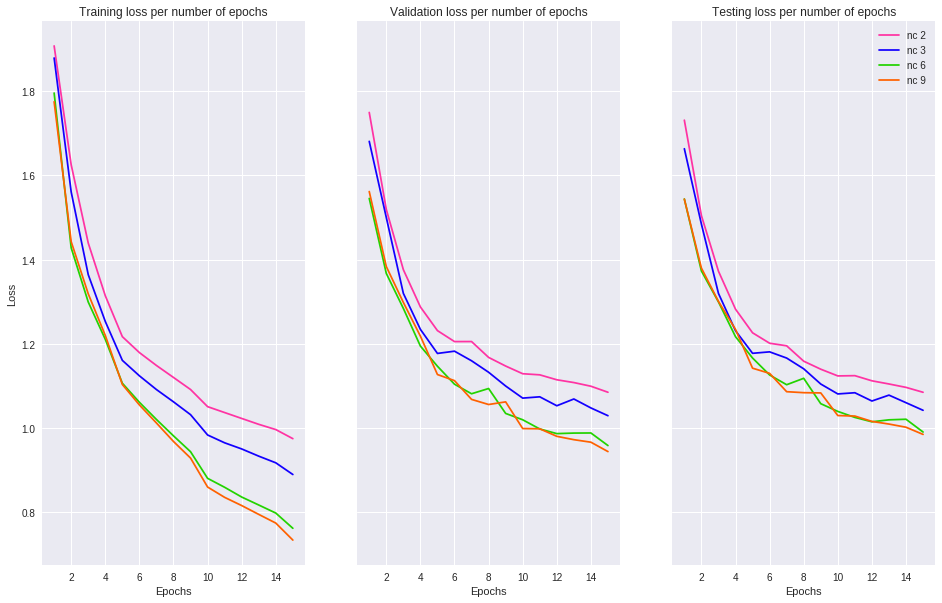

In [0]:
f, axes = plt.subplots(1, 3, sharey=True, figsize=(16, 10))
axes[0].set_ylabel("Loss")
losses = ["loss", "val_loss", "test_loss"]
titles = ["Training", "Validation", "Testing"]
for i in range(3):
    axes[i].plot(range(1, 16), histories_1f[losses[i]][2], '#ff33a3', label = "nc 2")
    axes[i].plot(range(1, 16), histories_1f[losses[i]][3], '#1300FF', label = "nc 3")
    axes[i].plot(range(1, 16), histories_1f[losses[i]][6], '#23D300', label = "nc 6")
    axes[i].plot(range(1, 16), histories_1f[losses[i]][9], '#FF6100', label = "nc 9")
    axes[i].grid(True)
    axes[i].set_title(titles[i]+" loss per number of epochs")
    axes[i].set_xlabel("Epochs")
axes[-1].legend()
plt.show()

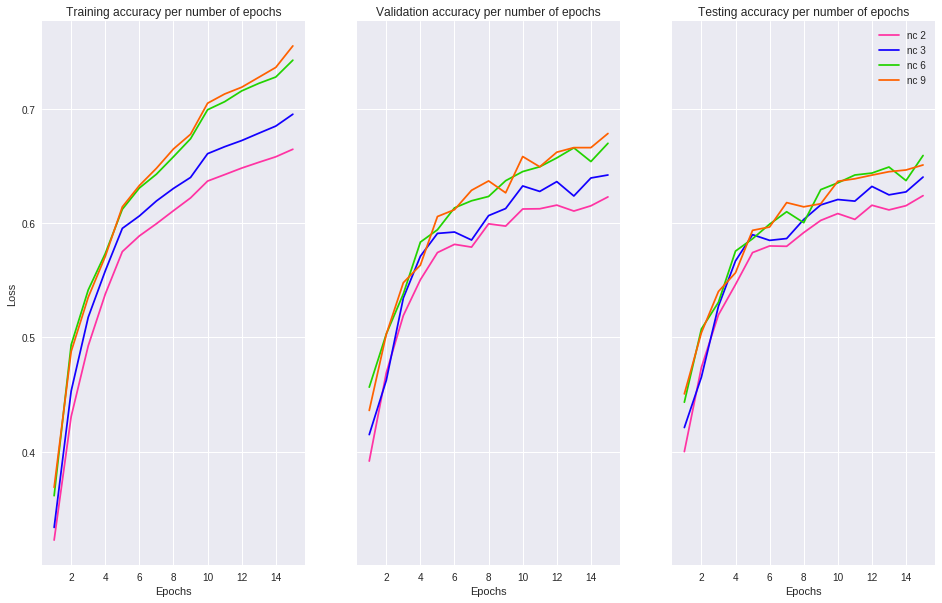

In [0]:
f, axes = plt.subplots(1, 3, sharey=True, figsize=(16, 10))
axes[0].set_ylabel("Loss")
acc = ["acc", "val_acc", "test_acc"]
titles = ["Training", "Validation", "Testing"]
for i in range(3):
    axes[i].plot(range(1, 16), histories_1f[acc[i]][2], '#ff33a3', label = "nc 2")
    axes[i].plot(range(1, 16), histories_1f[acc[i]][3], '#1300FF', label = "nc 3")
    axes[i].plot(range(1, 16), histories_1f[acc[i]][6], '#23D300', label = "nc 6")
    axes[i].plot(range(1, 16), histories_1f[acc[i]][9], '#FF6100', label = "nc 9")
    axes[i].grid(True)
    axes[i].set_title(titles[i]+" accuracy per number of epochs")
    axes[i].set_xlabel("Epochs")
axes[-1].legend()
plt.show()

### **Red con arquitectura Deep**
Ahora veremos el efecto de modificar el tamaño de los filtros en una red profunda.
Esta contará con una capa convolucional con 64 feature maps, donde los filtros tendrán tamaño 2, 3, 6 y 9. Luego se usa una capa pooling con filtro de tamaño 2, seguida con otras dos capas iguales a las anteriores. Después la capa de flatten, una capa de 512 neuronas con función de activación relu, para finalmente terminar con la capa final con 10 neuronas con función de activación softmax.

In [0]:
histories = dict()
for nc in [9, 6, 3, 2]:
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(64, (nc, nc), padding='same', input_shape = x_train.shape[1:]))
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Conv2D(64, (nc, nc), padding='same'))
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(512))
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.Dense(10))
    model.add(keras.layers.Activation('softmax'))
    test_loss = []
    test_acc = []
    opt = keras.optimizers.SGD(lr=0.0, momentum=0.9, decay=0.0)
    lrate = keras.callbacks.LearningRateScheduler(step_decay)
    model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, batch_size= 32, epochs = 15, validation_data=(x_val, y_val), shuffle=True, callbacks=[TestCallback((x_test, y_test)), lrate])
    history.history["test_loss"] = test_loss
    history.history["test_acc"] = test_acc
    histories[nc] = pd.DataFrame(history.history)

result = pd.concat(histories)
result.to_csv("history_1f_deep.csv")

Train on 45000 samples, validate on 5000 samples
Epoch 1/15
45000/45000 [==============================] - 23s 506us/step - loss: 1.8141 - acc: 0.3440 - val_loss: 1.5564 - val_acc: 0.4458

Testing loss: 1.5485328142166137, acc: 0.4437

Epoch 2/15
45000/45000 [==============================] - 18s 407us/step - loss: 1.4569 - acc: 0.4796 - val_loss: 1.3896 - val_acc: 0.5036

Testing loss: 1.3931790424346924, acc: 0.5081

Epoch 3/15
45000/45000 [==============================] - 18s 409us/step - loss: 1.2985 - acc: 0.5399 - val_loss: 1.2807 - val_acc: 0.5454

Testing loss: 1.2767142852783202, acc: 0.5467

Epoch 4/15
45000/45000 [==============================] - 18s 409us/step - loss: 1.1817 - acc: 0.5841 - val_loss: 1.1825 - val_acc: 0.5790

Testing loss: 1.1931077709198, acc: 0.5759

Epoch 5/15
45000/45000 [==============================] - 18s 408us/step - loss: 1.0415 - acc: 0.6383 - val_loss: 1.0693 - val_acc: 0.6312

Testing loss: 1.091819390296936, acc: 0.6171

Epoch 6/15
45000/450

Graficamos los 4 casos modelados para la arquitectura profunda:

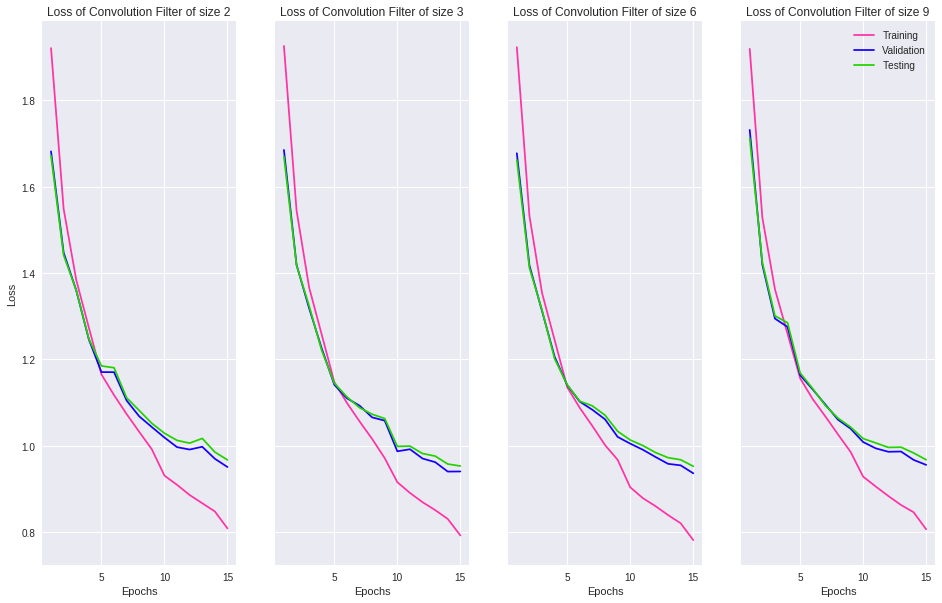

In [0]:
histories_1f = pd.read_csv("history_1f_deep.csv", dtype={'Unnamed: 0':int,'Unnamed: 1':int,'val_loss':float,
                                                    'loss': float}, index_col=[0,1], skipinitialspace=True)

nc = [2, 3, 6, 9]
f, axes = plt.subplots(1, 4, sharey=True, figsize=(16, 10))
axes[0].set_ylabel("Loss")
for i in range(len(nc)):
    axes[i].plot(range(1, 16), histories_1f['loss'][nc[i]], '#ff33a3', label = "Training")
    axes[i].plot(range(1, 16), histories_1f['val_loss'][nc[i]], '#1300FF', label = "Validation")
    axes[i].plot(range(1, 16), histories_1f['test_loss'][nc[i]], '#23D300', label = "Testing")
    axes[i].grid(True)
    axes[i].set_title("Loss of Convolution Filter of size "+str(nc[i]))
    axes[i].set_xlabel("Epochs")
axes[-1].legend()
plt.show()

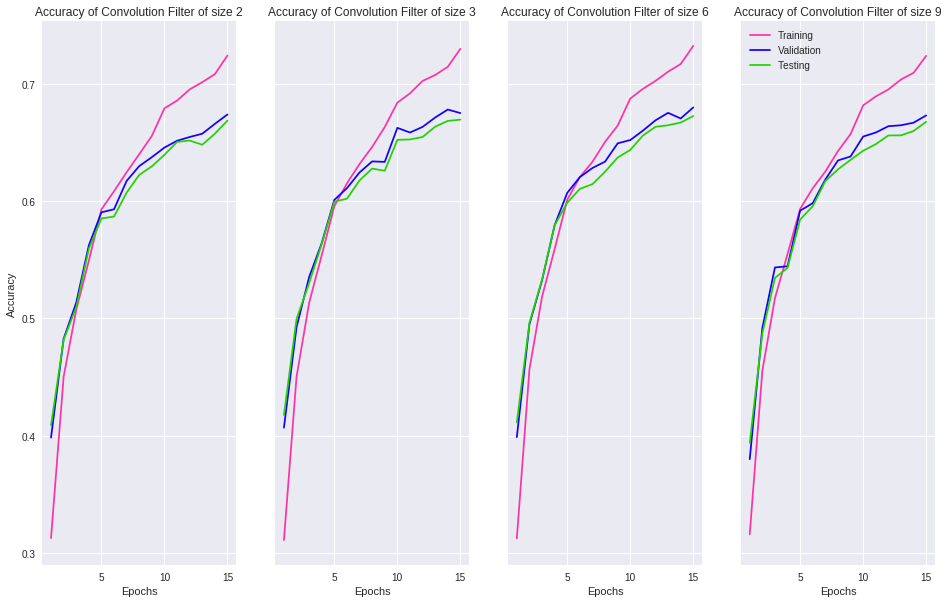

In [0]:
histories_1f = pd.read_csv("history_1f_deep.csv", dtype={'Unnamed: 0':int,'Unnamed: 1':int,'val_loss':float,
                                                    'loss': float}, index_col=[0,1], skipinitialspace=True)

nc = [2, 3, 6, 9]
f, axes = plt.subplots(1, 4, sharey=True, figsize=(16, 10))
axes[0].set_ylabel("Accuracy")
for i in range(len(nc)):
    axes[i].plot(range(1, 16), histories_1f['acc'][nc[i]], '#ff33a3', label = "Training")
    axes[i].plot(range(1, 16), histories_1f['val_acc'][nc[i]], '#1300FF', label = "Validation")
    axes[i].plot(range(1, 16), histories_1f['test_acc'][nc[i]], '#23D300', label = "Testing")
    axes[i].grid(True)
    axes[i].set_title("Accuracy of Convolution Filter of size "+str(nc[i]))
    axes[i].set_xlabel("Epochs")
axes[-1].legend()
plt.show()

A continuación se muestran gráficos para comparar el error de entrenamiento, validación y pruebas. Con esto poder comparar el efecto que tiene el cambio del tamaño del filtro convolucional.

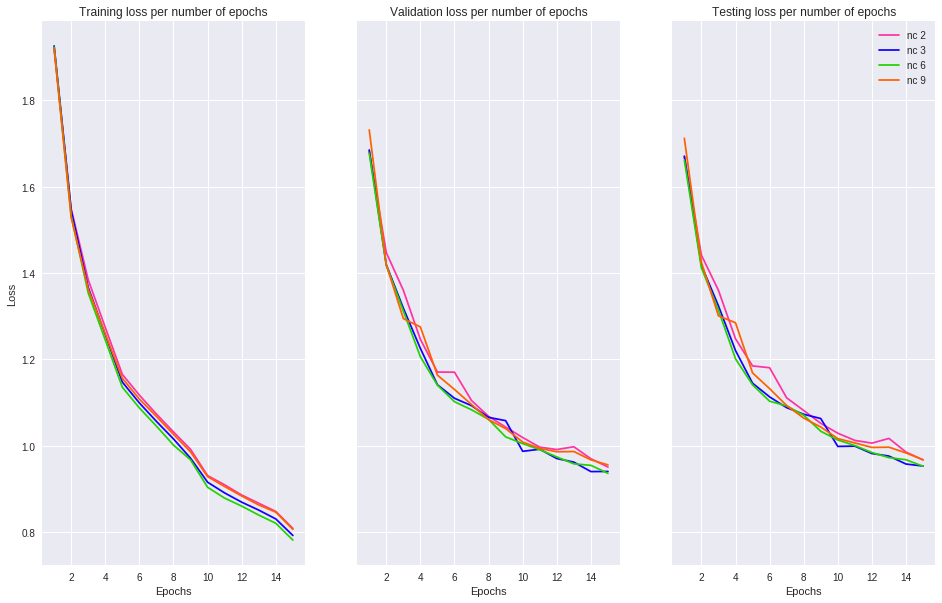

In [0]:
f, axes = plt.subplots(1, 3, sharey=True, figsize=(16, 10))
axes[0].set_ylabel("Loss")
losses = ["loss", "val_loss", "test_loss"]
titles = ["Training", "Validation", "Testing"]
for i in range(3):
    axes[i].plot(range(1, 16), histories_1f[losses[i]][2], '#ff33a3', label = "nc 2")
    axes[i].plot(range(1, 16), histories_1f[losses[i]][3], '#1300FF', label = "nc 3")
    axes[i].plot(range(1, 16), histories_1f[losses[i]][6], '#23D300', label = "nc 6")
    axes[i].plot(range(1, 16), histories_1f[losses[i]][9], '#FF6100', label = "nc 9")
    axes[i].grid(True)
    axes[i].set_title(titles[i]+" loss per number of epochs")
    axes[i].set_xlabel("Epochs")
axes[-1].legend()
plt.show()

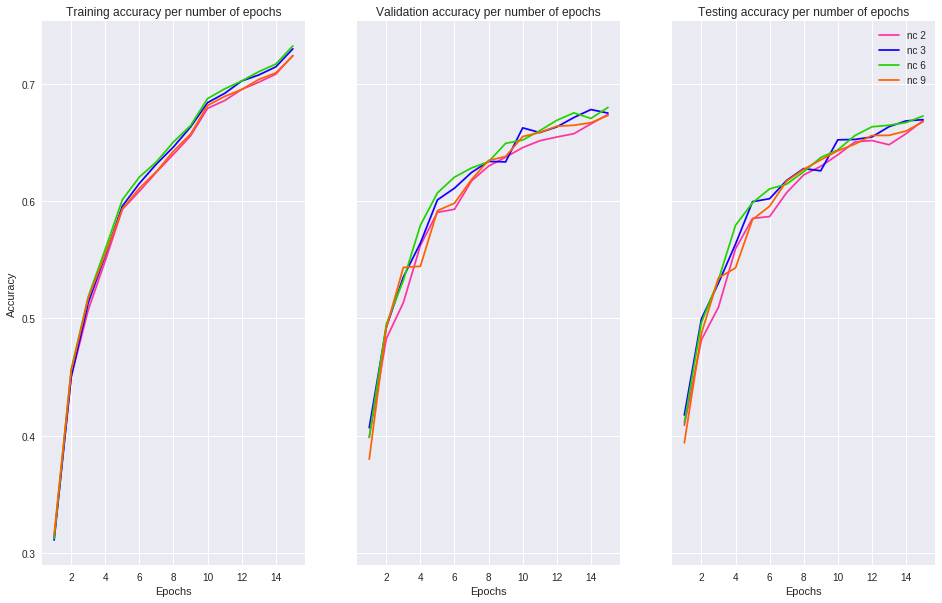

In [0]:
f, axes = plt.subplots(1, 3, sharey=True, figsize=(16, 10))
axes[0].set_ylabel("Accuracy")
losses = ["acc", "val_acc", "test_acc"]
titles = ["Training", "Validation", "Testing"]
for i in range(3):
    axes[i].plot(range(1, 16), histories_1f[losses[i]][2], '#ff33a3', label = "nc 2")
    axes[i].plot(range(1, 16), histories_1f[losses[i]][3], '#1300FF', label = "nc 3")
    axes[i].plot(range(1, 16), histories_1f[losses[i]][6], '#23D300', label = "nc 6")
    axes[i].plot(range(1, 16), histories_1f[losses[i]][9], '#FF6100', label = "nc 9")
    axes[i].grid(True)
    axes[i].set_title(titles[i]+" accuracy per number of epochs")
    axes[i].set_xlabel("Epochs")
axes[-1].legend()
plt.show()

La mayoría de las veces, vemos que los filtros en una capa convolucional aprenden a detectar conceptos abstractos, como el límite de una cara o los hombros de una persona. Al apilar capas de convoluciones una encima de la otra, podemos obtener información más abstracta y profunda.

Al aprender los valores de diferentes filtros, se puede notar que tener filtros mas grandes ayuda a que se construyan representaciones que extraen caracteristicas de entrada mas gruesas y generales, que usar filtros pequeños ya que se estarian aprendiendo caracteristicas muy especificas.  La segunda capa de convolución podría detectar las formas ó bordes y así sucesivamente. Esto también permite que las CNN realicen el aprendizaje jerárquico de características, al crear filtros muy chicos no se van a extraer correctamente los caracteristicas para clasificación lo que conduce a tener un error de entrenamiento mayor, ya podría confundir algunas imagenes similares.  En el caso de la arquitectura shallow, lo anterior podría suceder.





---


## Pregunta G

> Se ha sugerido que la práctica bastante habitual de continuar una capa convolucional con una capa de *pooling* puede generar una reducción prematura de las dimensiones del patrón de entrada. Experimente con una arquitectura del tipo $C \times P \times C \times P \times F \times F$ versus  $C \times C \times P \times C \times C \times P \times F \times F$. Use 64 filtros para la primera capa convolucional y 128 para la segunda (o 64 filtros para las primeras 2 capas convolucionales y 128 para las dos últimas).

> Reflexione sobre qué le parece más sensato: ¿qué estructura permite un mejor desempeño y/o extracción de atributos de interés?¿es aconsejable mantener el tamaño de los filtros usados anteriormente (pregunta anterior)? o ¿usar filtros más grandes en la segunda capa convolucional y más pequeños en la primera? o ¿usar filtros más pequeños en la segunda capa convolucional y más grandes en la primera?  
> **Hint:** con esta nueva arquitectura debiese superar el 70% de accuracy (de validación/test) antes de 5 epochs, pero la arquitectura es más sensible a overfitting por lo que podrı́a ser conveniente agregar un regularizador. Como resultado final de esta actividad gráfique los errores de entrenamiento, validación y pruebas como función del número de “epochs” (fijando el máximo en un número razonable como T = 25).

### Modelos compilados de la arquitectura **C×P×C×P×F×F **  (64 filtros primera capa  y 128 filtros segunda capa convolucional)   
Para varias combinaciones de tamaños de filtro de convolución. Luego entrenamos cada modelo para comparar sus resultados.

In [0]:
ncs = [(3, 3), (6, 6), (3, 6), (6, 3)]
models = np.empty((4, ), dtype=object)
opt = keras.optimizers.rmsprop(lr=0.001, decay=1e-6)
#opt = keras.optimizers.SGD(lr=0.0, momentum=0.9, decay=0.0)

for i in range(len(ncs)):
    nc1, nc2 = ncs[i]
    models[i] = keras.models.Sequential()
    models[i].add(keras.layers.Conv2D(64, (nc1, nc1), padding='same', input_shape = x_train.shape[1:],
                                   kernel_regularizer = keras.regularizers.l2(0.01)))
    models[i].add(keras.layers.Activation('relu'))
    models[i].add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    models[i].add(keras.layers.Dropout(0.4))
    models[i].add(keras.layers.Conv2D(128, (nc2, nc2), padding='same', kernel_regularizer = keras.regularizers.l2(0.01)))
    models[i].add(keras.layers.Activation('relu'))
    models[i].add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    models[i].add(keras.layers.Dropout(0.1))
    models[i].add(keras.layers.Flatten())
    models[i].add(keras.layers.Dense(512))
    models[i].add(keras.layers.Activation('relu'))
    models[i].add(keras.layers.Dense(10))
    models[i].add(keras.layers.Activation('softmax'))
    models[i].compile(optimizer = opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
lrate = keras.callbacks.LearningRateScheduler(step_decay)
histories = dict()
for i in range(len(models)):
    test_loss = []
    test_acc = []
    history = models[i].fit(x_train, y_train, batch_size= 32, epochs = 15, validation_data=(x_val, y_val), shuffle=True, callbacks=[TestCallback((x_test, y_test)), lrate])
    history.history["test_loss"] = test_loss
    history.history["test_acc"] = test_acc
    histories[i] = pd.DataFrame(history.history)

result = pd.concat(histories)
result.to_csv("histories_1g_shallow.csv")

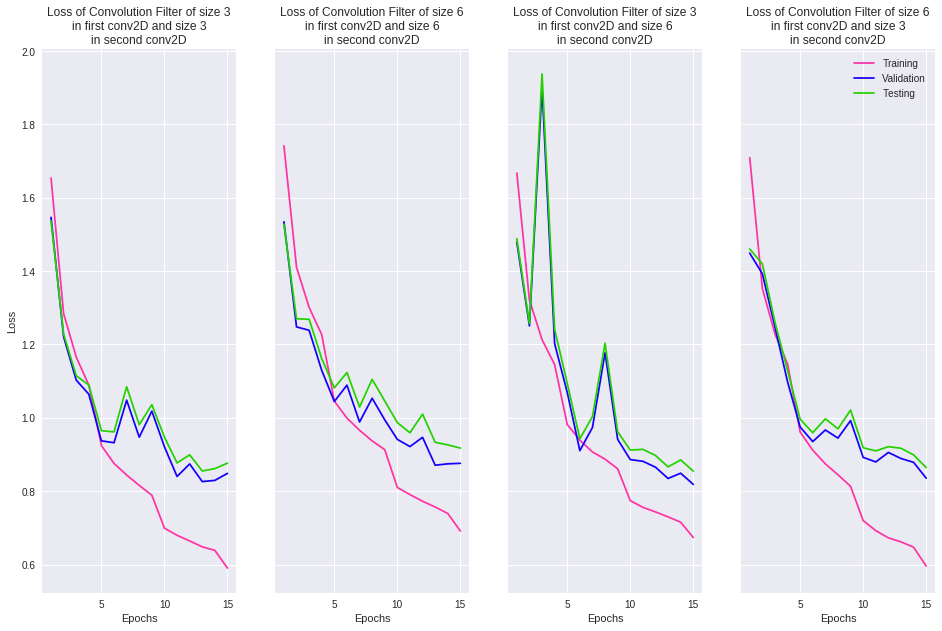

In [0]:
ncs = [(3, 3), (6, 6), (3, 6), (6, 3)]
histories_1g_shallow = pd.read_csv("histories_1g_shallow.csv", dtype={'Unnamed: 0':int,'Unnamed: 1':int,'val_loss':float,
                                                    'loss': float}, index_col=[0,1], skipinitialspace=True)

f, axes = plt.subplots(1, 4, sharey=True, figsize=(16, 10))
axes[0].set_ylabel("Loss")
for i in range(4):
    axes[i].plot(range(1, 16), histories_1g_shallow['loss'][i], '#ff33a3', label = "Training")
    axes[i].plot(range(1, 16), histories_1g_shallow['val_loss'][i], '#1300FF', label = "Validation")
    axes[i].plot(range(1, 16), histories_1g_shallow['test_loss'][i], '#23D300', label = "Testing")
    axes[i].grid(True)
    axes[i].set_title("Loss of Convolution Filter of size "+str(ncs[i][0])+"\nin first conv2D and size "+str(ncs[i][1])+"\nin second conv2D")
    axes[i].set_xlabel("Epochs")
axes[-1].legend()
plt.show()

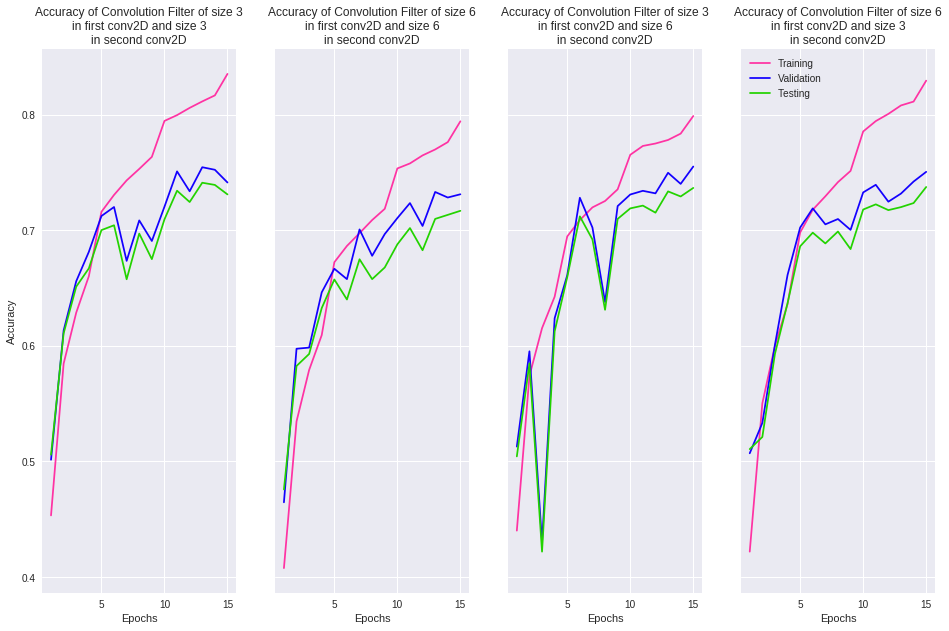

In [0]:
histories_1g_shallow = pd.read_csv("histories_1g_shallow.csv", dtype={'Unnamed: 0':int,'Unnamed: 1':int,'val_loss':float,
                                                    'loss': float}, index_col=[0,1], skipinitialspace=True)

f, axes = plt.subplots(1, 4, sharey=True, figsize=(16, 10))
axes[0].set_ylabel("Accuracy")
for i in range(4):
    axes[i].plot(range(1, 16), histories_1g_shallow['acc'][i], '#ff33a3', label = "Training")
    axes[i].plot(range(1, 16), histories_1g_shallow['val_acc'][i], '#1300FF', label = "Validation")
    axes[i].plot(range(1, 16), histories_1g_shallow['test_acc'][i], '#23D300', label = "Testing")
    axes[i].grid(True)
    axes[i].set_title("Accuracy of Convolution Filter of size "+str(ncs[i][0])+"\nin first conv2D and size "+str(ncs[i][1])+"\nin second conv2D")
    axes[i].set_xlabel("Epochs")
axes[-1].legend()
plt.show()

### Modelos compilados de la arquitectura **C×P×C×P×F×F **  (128 filtros primera capa  y 64 filtros segunda capa convolucional)   
Para varias combinaciones de tamaños de filtro de convolución. Luego entrenamos cada modelo para comparar sus resultados.

In [0]:
ncs = [(3, 3), (6, 6), (3, 6), (6, 3)]
models = np.empty((4, ), dtype=object)
opt = keras.optimizers.rmsprop(lr=0.001, decay=1e-6)

for i in range(len(ncs)):
    nc1, nc2 = ncs[i]
    models[i] = keras.models.Sequential()
    models[i].add(keras.layers.Conv2D(128, (nc1, nc1), padding='same', input_shape = x_train.shape[1:],
                                   kernel_regularizer = keras.regularizers.l2(0.01)))
    models[i].add(keras.layers.Activation('relu'))
    models[i].add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    models[i].add(keras.layers.Dropout(0.4))
    models[i].add(keras.layers.Conv2D(64, (nc2, nc2), padding='same', kernel_regularizer = keras.regularizers.l2(0.01)))
    models[i].add(keras.layers.Activation('relu'))
    models[i].add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    models[i].add(keras.layers.Dropout(0.1))
    models[i].add(keras.layers.Flatten())
    models[i].add(keras.layers.Dense(512))
    models[i].add(keras.layers.Activation('relu'))
    models[i].add(keras.layers.Dense(10))
    models[i].add(keras.layers.Activation('softmax'))
    models[i].compile(optimizer = opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
lrate = keras.callbacks.LearningRateScheduler(step_decay)
histories = dict()
for i in range(len(models)):
    test_loss = []
    test_acc = []
    history = models[i].fit(x_train, y_train, batch_size= 32, epochs = 15, validation_data=(x_val, y_val), shuffle=True, callbacks=[TestCallback((x_test, y_test)), lrate])
    history.history["test_loss"] = test_loss
    history.history["test_acc"] = test_acc
    histories[i] = pd.DataFrame(history.history)

result = pd.concat(histories)
result.to_csv("histories_1g2_shallow.csv")

Train on 45000 samples, validate on 5000 samples
Epoch 1/15
45000/45000 [==============================] - 28s 632us/step - loss: 1.6858 - acc: 0.4321 - val_loss: 1.3678 - val_acc: 0.5518

Testing loss: 1.383875415802002, acc: 0.5421

Epoch 2/15
45000/45000 [==============================] - 23s 506us/step - loss: 1.3077 - acc: 0.5698 - val_loss: 1.2103 - val_acc: 0.6098

Testing loss: 1.2264589109420776, acc: 0.5958

Epoch 3/15
45000/45000 [==============================] - 23s 503us/step - loss: 1.1802 - acc: 0.6158 - val_loss: 1.0716 - val_acc: 0.6604

Testing loss: 1.104940445804596, acc: 0.6431

Epoch 4/15
45000/45000 [==============================] - 23s 502us/step - loss: 1.1048 - acc: 0.6462 - val_loss: 1.1016 - val_acc: 0.6582

Testing loss: 1.1284089763641358, acc: 0.6387

Epoch 5/15
45000/45000 [==============================] - 23s 501us/step - loss: 0.9341 - acc: 0.7051 - val_loss: 1.0248 - val_acc: 0.6762

Testing loss: 1.059252479171753, acc: 0.6595

Epoch 6/15
45000/45

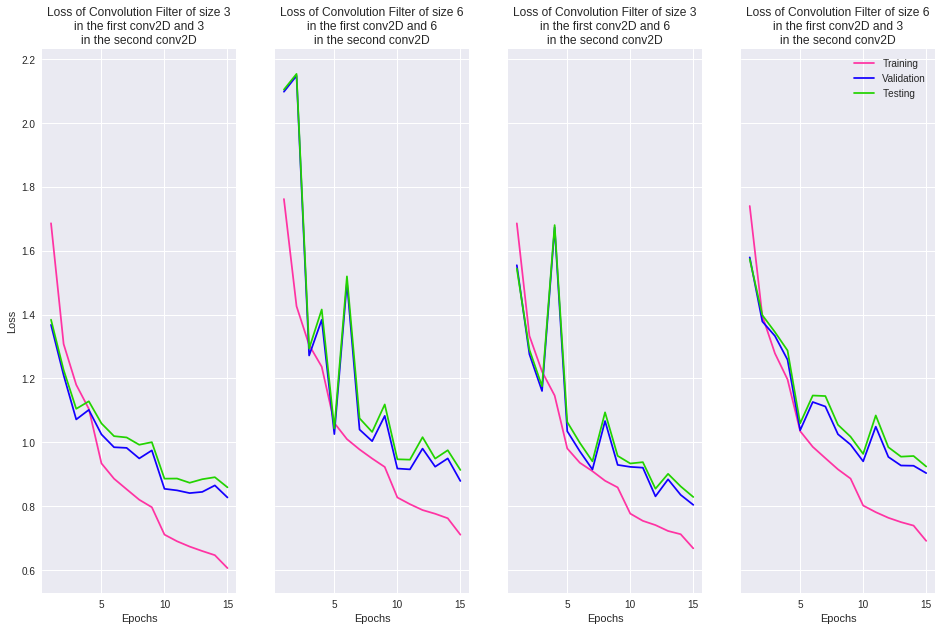

In [26]:
ncs = [(3, 3), (6, 6), (3, 6), (6, 3)]
histories_1g_shallow = pd.read_csv("histories_1g2_shallow.csv", dtype={'Unnamed: 0':int,'Unnamed: 1':int,'val_loss':float,
                                                    'loss': float}, index_col=[0,1], skipinitialspace=True)

f, axes = plt.subplots(1, 4, sharey=True, figsize=(16, 10))
axes[0].set_ylabel("Loss")
for i in range(4):
    axes[i].plot(range(1, 16), histories_1g_shallow['loss'][i], '#ff33a3', label = "Training")
    axes[i].plot(range(1, 16), histories_1g_shallow['val_loss'][i], '#1300FF', label = "Validation")
    axes[i].plot(range(1, 16), histories_1g_shallow['test_loss'][i], '#23D300', label = "Testing")
    axes[i].grid(True)
    axes[i].set_title("Loss of Convolution Filter of size "+str(ncs[i][0])+"\nin the first conv2D and "+str(ncs[i][1])+"\nin the second conv2D")
    axes[i].set_xlabel("Epochs")
axes[-1].legend()
plt.show()

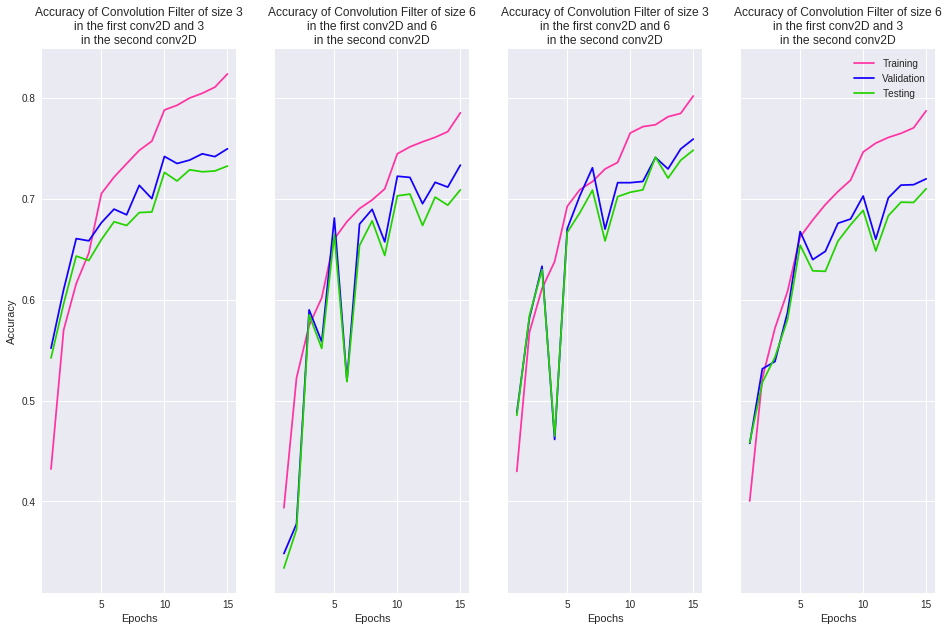

In [24]:
ncs = [(3, 3), (6, 6), (3, 6), (6, 3)]
histories_1g_shallow = pd.read_csv("histories_1g2_shallow.csv", dtype={'Unnamed: 0':int,'Unnamed: 1':int,'val_loss':float,
                                                    'loss': float}, index_col=[0,1], skipinitialspace=True)

f, axes = plt.subplots(1, 4, sharey=True, figsize=(16, 10))
axes[0].set_ylabel("Accuracy")
for i in range(4):
    axes[i].plot(range(1, 16), histories_1g_shallow['acc'][i], '#ff33a3', label = "Training")
    axes[i].plot(range(1, 16), histories_1g_shallow['val_acc'][i], '#1300FF', label = "Validation")
    axes[i].plot(range(1, 16), histories_1g_shallow['test_acc'][i], '#23D300', label = "Testing")
    axes[i].grid(True)
    axes[i].set_title("Accuracy of Convolution Filter of size "+str(ncs[i][0])+"\nin the first conv2D and "+str(ncs[i][1])+"\nin the second conv2D")
    axes[i].set_xlabel("Epochs")
axes[-1].legend()
plt.show()

### Modelos compilados de la arquitectura **C×C×P×C×C×P×F×F **  (64 filtros primera capa y 128 filtros segunda capa convolucional)
Para varias combinaciones de tamaños de filtro de convolución. Luego entrenamos cada modelo para comparar sus resultados.

In [0]:
ncs = [(3, 3), (6, 6), (3, 6), (6, 3)]
models = np.empty((4, ), dtype=object)
opt = keras.optimizers.rmsprop(lr=0.001, decay=1e-6)

for i in range(len(ncs)):
    nc1, nc2 = ncs[i]
    models[i] = keras.models.Sequential()
    models[i].add(keras.layers.Conv2D(64, (nc1, nc1), padding='same', input_shape = x_train.shape[1:],
                                   kernel_regularizer = keras.regularizers.l2(0.005)))
    models[i].add(keras.layers.Activation('relu'))
    models[i].add(keras.layers.Conv2D(64, (nc1, nc1), padding='same', kernel_regularizer = keras.regularizers.l2(0.0013)))
    models[i].add(keras.layers.Activation('relu'))
    models[i].add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    models[i].add(keras.layers.Dropout(0.4))
    models[i].add(keras.layers.Conv2D(128, (nc2, nc2), padding='same', kernel_regularizer = keras.regularizers.l2(0.005)))
    models[i].add(keras.layers.Activation('relu'))
    models[i].add(keras.layers.Conv2D(128, (nc2, nc2), padding='same', kernel_regularizer = keras.regularizers.l2(0.0013)))
    models[i].add(keras.layers.Activation('relu'))
    models[i].add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    models[i].add(keras.layers.Dropout(0.1))
    models[i].add(keras.layers.Flatten())
    models[i].add(keras.layers.Dense(512))
    models[i].add(keras.layers.Activation('relu'))
    models[i].add(keras.layers.Dense(10))
    models[i].add(keras.layers.Activation('softmax'))
    models[i].compile(optimizer = opt, loss='categorical_crossentropy', metrics=['accuracy'])

lrate = keras.callbacks.LearningRateScheduler(step_decay)
histories = dict()
for i in range(len(models)):
    test_loss = []
    test_acc = []
    history = models[i].fit(x_train, y_train, batch_size= 32, epochs = 15, validation_data=(x_val, y_val), shuffle=True, callbacks=[TestCallback((x_test, y_test)), lrate])
    history.history["test_loss"] = test_loss
    history.history["test_acc"] = test_acc
    histories[i] = pd.DataFrame(history.history)

result = pd.concat(histories)
result.to_csv("histories_1g_deep.csv")

Train on 45000 samples, validate on 5000 samples
Epoch 1/15
45000/45000 [==============================] - 40s 881us/step - loss: 1.7194 - acc: 0.4016 - val_loss: 1.3820 - val_acc: 0.5304

Testing loss: 1.3922187784194946, acc: 0.5238

Epoch 2/15
45000/45000 [==============================] - 38s 848us/step - loss: 1.2784 - acc: 0.5710 - val_loss: 1.2891 - val_acc: 0.5966

Testing loss: 1.316489521598816, acc: 0.5767

Epoch 3/15
45000/45000 [==============================] - 38s 850us/step - loss: 1.1217 - acc: 0.6314 - val_loss: 1.0666 - val_acc: 0.6632

Testing loss: 1.0944605931282043, acc: 0.6521

Epoch 4/15
45000/45000 [==============================] - 39s 864us/step - loss: 1.0199 - acc: 0.6741 - val_loss: 1.0132 - val_acc: 0.6770

Testing loss: 1.0283607248306275, acc: 0.6704

Epoch 5/15
45000/45000 [==============================] - 38s 847us/step - loss: 0.8441 - acc: 0.7364 - val_loss: 0.8529 - val_acc: 0.7418

Testing loss: 0.8828332215309143, acc: 0.7259

Epoch 6/15
45000/

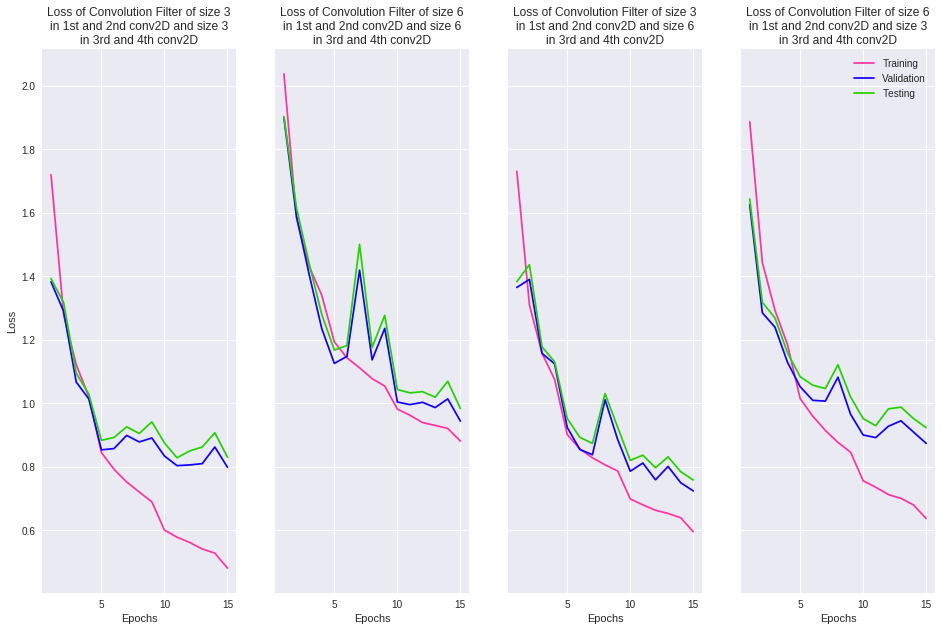

In [0]:
ncs = [(3, 3), (6, 6), (3, 6), (6, 3)]
histories_1g_deep = pd.read_csv("histories_1g_deep.csv", dtype={'Unnamed: 0':int,'Unnamed: 1':int,'val_loss':float,
                                                    'loss': float}, index_col=[0,1], skipinitialspace=True)

f, axes = plt.subplots(1, 4, sharey=True, figsize=(16, 10))
axes[0].set_ylabel("Loss")
for i in range(4):
    axes[i].plot(range(1, 16), histories_1g_deep['loss'][i], '#ff33a3', label = "Training")
    axes[i].plot(range(1, 16), histories_1g_deep['val_loss'][i], '#1300FF', label = "Validation")
    axes[i].plot(range(1, 16), histories_1g_deep['test_loss'][i], '#23D300', label = "Testing")
    axes[i].grid(True)
    axes[i].set_title("Loss of Convolution Filter of size "+str(ncs[i][0])+"\nin 1st and 2nd conv2D and size "+str(ncs[i][1])+"\nin 3rd and 4th conv2D")
    axes[i].set_xlabel("Epochs")
axes[-1].legend()
plt.show()

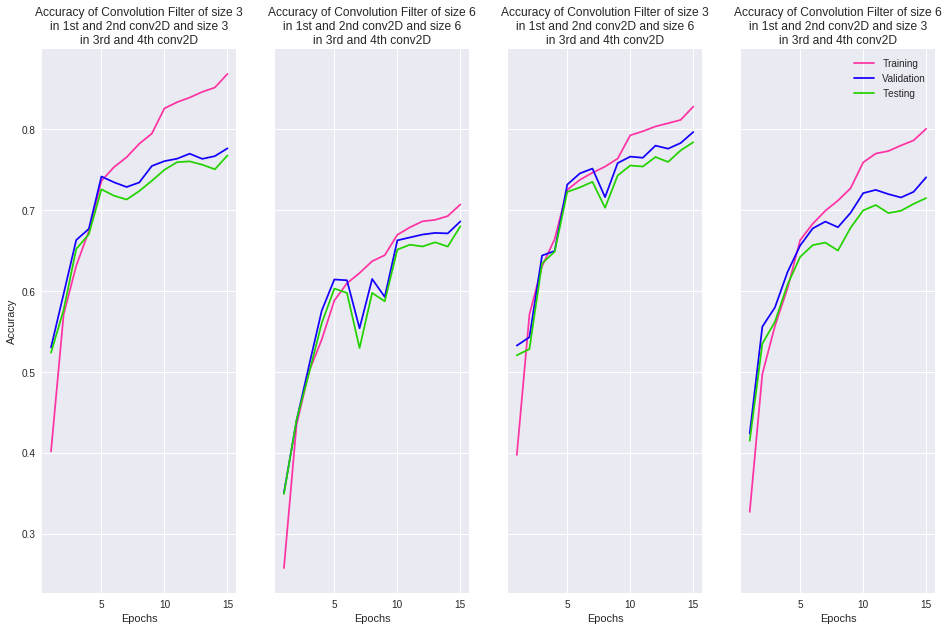

In [0]:
histories_1g_deep = pd.read_csv("histories_1g_deep.csv", dtype={'Unnamed: 0':int,'Unnamed: 1':int,'val_loss':float,
                                                    'loss': float}, index_col=[0,1], skipinitialspace=True)

f, axes = plt.subplots(1, 4, sharey=True, figsize=(16, 10))
axes[0].set_ylabel("Accuracy")
for i in range(4):
    axes[i].plot(range(1, 16), histories_1g_deep['acc'][i], '#ff33a3', label = "Training")
    axes[i].plot(range(1, 16), histories_1g_deep['val_acc'][i], '#1300FF', label = "Validation")
    axes[i].plot(range(1, 16), histories_1g_deep['test_acc'][i], '#23D300', label = "Testing")
    axes[i].grid(True)
    axes[i].set_title("Accuracy of Convolution Filter of size "+str(ncs[i][0])+"\nin 1st and 2nd conv2D and size "+str(ncs[i][1])+"\nin 3rd and 4th conv2D")
    axes[i].set_xlabel("Epochs")
axes[-1].legend()
plt.show()

Parece sensato que la arquitectura  C×C×P×C×C×P×F×F  permite una mayor extracción de atributos de interés, seria recomendable tener filtros mas grandes cuanto mas cerca se este de la entrada, y luego empezar a decaer jerarquicamente para extraer caracteristicas finas. Por lo que sería recomendable utilizar filtros de 128 en la entrada y luego de 64.

En general, con las dos arquitecturas se obtiene un gran desempeño y aumenta significativamente la exactitud del algoritmo. También añadir la importancia de incluir un regularizador en nuestro caso elegimos regularizador weight decay para evitar el overfitting.



---


## Pregunta H
> Algunos investigadores, han propuesto que las capas de *pooling* se pueden reemplazar por capas convoluciones con stride 2. ¿Se reduce dimensionalidad de este modo? Compruébelo verificando los cambios de forma (dimensionalidad) que experimenta un patrón de entrada a medida que se ejecuta un *forward-pass*.  
Entrene la red resultante con el método que prefiera, gráficando los errores de entrenamiento, validación y pruebas como función del número de “epochs” (fijando el máximo en un número razonable como T = 25).

Reemplazando las capas de pooling del punto c) por capas convolucionales con stride 2, se obtiene la siguiente arquitectura:

In [0]:
modelh = keras.models.Sequential()
modelh.add(keras.layers.Conv2D(64, (3, 3), padding='same', input_shape = x_train.shape[1:]))
modelh.add(keras.layers.Activation('relu'))
modelh.add(keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
modelh.add(keras.layers.Conv2D(64, (3, 3), padding='same'))
modelh.add(keras.layers.Activation('relu'))
modelh.add(keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
modelh.add(keras.layers.Flatten())
modelh.add(keras.layers.Dense(512))
modelh.add(keras.layers.Activation('relu'))
modelh.add(keras.layers.Dense(10))
modelh.add(keras.layers.Activation('softmax'))
modelh.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_9 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
activation_10 (Activation)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 4096)              0         
__________

Las capas de pooling pueden reemplazarse por un tipo especial de convolución llamada "dilated convolution". Las convoluciones normales con stride 2, también se pueden considerarse convoluciones dilatadas.

Las capas de pooling con filtros de 2x2 que extraen en valor máximo de cada región, en esta capa no hay parámetros para aprender solo se utiliza para disminuir la dimensionalidad. Al ser reemplazados por capas con convolución y stride 2 se añaden más parámetros para entrenar, no se disminuye la dimensionalidad antes se ayuda a preservar la información espacial así como la resolución general y genera resultados con dimensión exacta que las imágenes de entrada.

In [0]:
test_loss = []
test_acc = []
opt = keras.optimizers.SGD(lr=0.0, momentum=0.9, decay=0.0)
lrate = keras.callbacks.LearningRateScheduler(step_decay)
modelh.compile(optimizer = opt, loss='categorical_crossentropy', metrics=['accuracy'])
historyh = modelh.fit(x_train, y_train,batch_size = 128, epochs=25, validation_data=(x_val,y_val), shuffle=True, callbacks=[TestCallback((x_test, y_test)),lrate])
historyh.history["test_loss"] = test_loss
historyh.history["test_acc"] = test_loss
result = pd.DataFrame(historyh.history)
result.to_csv("history_1h.csv")

Train on 45000 samples, validate on 5000 samples
Epoch 1/25
45000/45000 [==============================] - 13s 282us/step - loss: 2.1243 - acc: 0.2294 - val_loss: 1.9020 - val_acc: 0.3260

Testing loss: 1.8908370315551757, acc: 0.3337

Epoch 2/25
45000/45000 [==============================] - 12s 267us/step - loss: 1.8183 - acc: 0.3613 - val_loss: 1.7498 - val_acc: 0.3772

Testing loss: 1.7324062589645386, acc: 0.3864

Epoch 3/25
45000/45000 [==============================] - 12s 269us/step - loss: 1.6755 - acc: 0.4117 - val_loss: 1.6106 - val_acc: 0.4268

Testing loss: 1.5950102436065674, acc: 0.4336

Epoch 4/25
45000/45000 [==============================] - 12s 266us/step - loss: 1.5684 - acc: 0.4480 - val_loss: 1.5498 - val_acc: 0.4510

Testing loss: 1.532362329864502, acc: 0.4513

Epoch 5/25
45000/45000 [==============================] - 12s 269us/step - loss: 1.4821 - acc: 0.4772 - val_loss: 1.4867 - val_acc: 0.4704

Testing loss: 1.4727979637145996, acc: 0.4769

Epoch 6/25
45000/

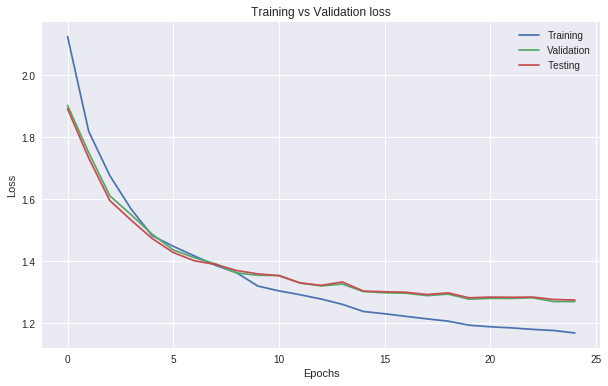

In [0]:
history_1h = pd.read_csv("history_1h.csv")
plotCurves([history_1h['loss'], history_1h['val_loss'], history_1h['test_loss']], ['Epochs', 'Loss'], 'Training vs Validation loss', ['Training', 'Validation','Testing'])



---

## Pregunta I

>  Una forma interesante de regularizar modelos entrenados para visión artificial consiste en “aumentar” el número de ejemplos de entrenamiento usando transformaciones sencillas como: rotaciones, corrimientos y reflexiones, tanto horizontales como verticales. Explique por qué este procedimiento podrı́a ayudar a mejorar el modelo y el por qué las etiquetas no cambian al aplicar estas operaciones. Evalúe experimentalmente la conveniencia de incorporarlo.

Se define uno de los modelos con mejores resultados (0.7842 accuracy a la 15ava epoch) para aumentar sus ejemplos de entrenamiento. Es el modelo de una red Deep con 2 capas de convolución iniciales con tamaño de filtro 3 y 2 capas de convolución finales con tamaño de filtro 6.

In [0]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, (3, 3), padding='same', input_shape = x_train.shape[1:], kernel_regularizer = keras.regularizers.l2(0.005)))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer = keras.regularizers.l2(0.0013)))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Conv2D(128, (6, 6), padding='same', kernel_regularizer = keras.regularizers.l2(0.005)))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Conv2D(128, (6, 6), padding='same', kernel_regularizer = keras.regularizers.l2(0.0013)))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dense(10))
model.add(keras.layers.Activation('softmax'))

opt = keras.optimizers.rmsprop(lr=0.001, decay=1e-6)
model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
test_loss = []
test_acc = []
lrate = keras.callbacks.LearningRateScheduler(step_decay)
history_1i = model.fit(x_train, y_train, batch_size= 32, epochs = 25, validation_data = (x_val, y_val), shuffle=True, callbacks=[TestCallback((x_test, y_test)), lrate])
history_1i.history["test_loss"] = test_loss
history_1i.history["test_acc"] = test_acc
result = pd.DataFrame(history_1i.history)
result.to_csv("history_1i_original.csv")

Train on 45000 samples, validate on 5000 samples
Epoch 1/25
45000/45000 [==============================] - 50s 1ms/step - loss: 1.7999 - acc: 0.3676 - val_loss: 1.5652 - val_acc: 0.4522

Testing loss: 1.6192774196624755, acc: 0.4343

Epoch 2/25
45000/45000 [==============================] - 49s 1ms/step - loss: 1.3348 - acc: 0.5514 - val_loss: 1.8431 - val_acc: 0.3730

Testing loss: 1.8952166549682616, acc: 0.3678

Epoch 3/25
45000/45000 [==============================] - 49s 1ms/step - loss: 1.2016 - acc: 0.6072 - val_loss: 1.1688 - val_acc: 0.6116

Testing loss: 1.1878413038253783, acc: 0.6109

Epoch 4/25
45000/45000 [==============================] - 49s 1ms/step - loss: 1.1150 - acc: 0.6394 - val_loss: 1.0441 - val_acc: 0.6698

Testing loss: 1.0833754188537599, acc: 0.6598

Epoch 5/25
45000/45000 [==============================] - 49s 1ms/step - loss: 0.9502 - acc: 0.6972 - val_loss: 0.9976 - val_acc: 0.6888

Testing loss: 1.0394021207809447, acc: 0.6792

Epoch 6/25
45000/45000 [==

In [0]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False, # set input mean to 0 over the dataset
    samplewise_center=False, # set each sample mean to 0
    featurewise_std_normalization=False, # divide inputs by std of the dataset
    samplewise_std_normalization=False, # divide each input by its std
    zca_whitening=False, # apply ZCA whitening
    rotation_range=0, # randomly rotate images (degrees, 0 to 180)
    width_shift_range=0.1, # randomly shift images horizontally (fraction of width)
    height_shift_range=0.1, # randomly shift images vertically (fraction of height)
    horizontal_flip=True, # randomly flip images
    vertical_flip=False) # randomly flip images
datagen.fit(x_train)

test_loss = []
test_acc = []
lrate = keras.callbacks.LearningRateScheduler(step_decay)
history_1i = model.fit_generator(datagen.flow(x_train, y_train, batch_size = 32), steps_per_epoch = x_train.shape[0]//32, epochs = 25, validation_data=(x_test, y_test), callbacks=[TestCallback((x_test, y_test)), lrate])
history_1i.history["test_loss"] = test_loss
history_1i.history["test_acc"] = test_acc
result = pd.DataFrame(history_1i.history)
result.to_csv("history_1i.csv")

Epoch 1/25
1406/1406 [==============================] - 52s 37ms/step - loss: 1.4055 - acc: 0.5235 - val_loss: 1.1691 - val_acc: 0.6145

Testing loss: 1.1690894159317016, acc: 0.6145

Epoch 2/25
1406/1406 [==============================] - 52s 37ms/step - loss: 1.3098 - acc: 0.5679 - val_loss: 1.1316 - val_acc: 0.6295

Testing loss: 1.1315586345672608, acc: 0.6295

Epoch 3/25
1406/1406 [==============================] - 51s 37ms/step - loss: 1.2559 - acc: 0.5909 - val_loss: 1.1082 - val_acc: 0.6489

Testing loss: 1.1081578321456909, acc: 0.6489

Epoch 4/25
1406/1406 [==============================] - 52s 37ms/step - loss: 1.2118 - acc: 0.6081 - val_loss: 1.0986 - val_acc: 0.6461

Testing loss: 1.098643621826172, acc: 0.6461

Epoch 5/25
1406/1406 [==============================] - 52s 37ms/step - loss: 1.0723 - acc: 0.6570 - val_loss: 0.9260 - val_acc: 0.7113

Testing loss: 0.9260260106086731, acc: 0.7113

Epoch 6/25
1406/1406 [==============================] - 51s 36ms/step - loss: 1.0

Se muestran los graficos obtenidos comparando los resultados obtenidos al aumentar la data con un modelo entrenado anteriormente:

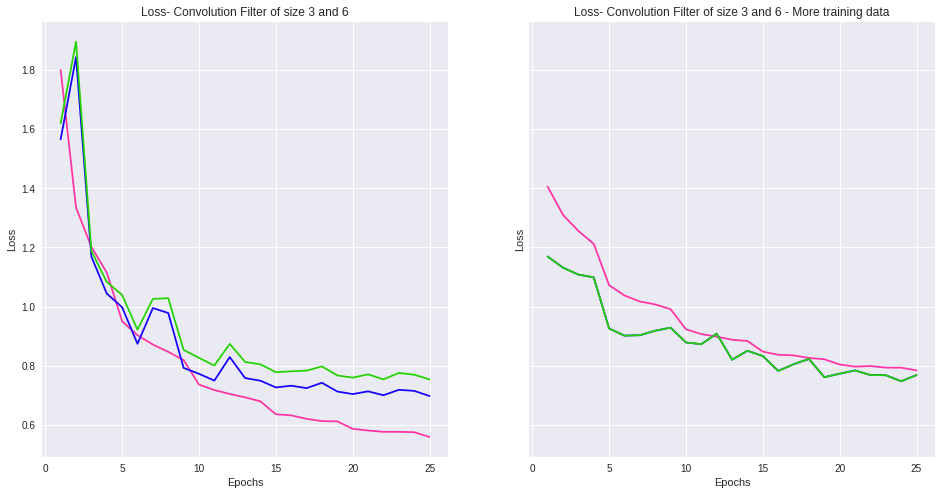

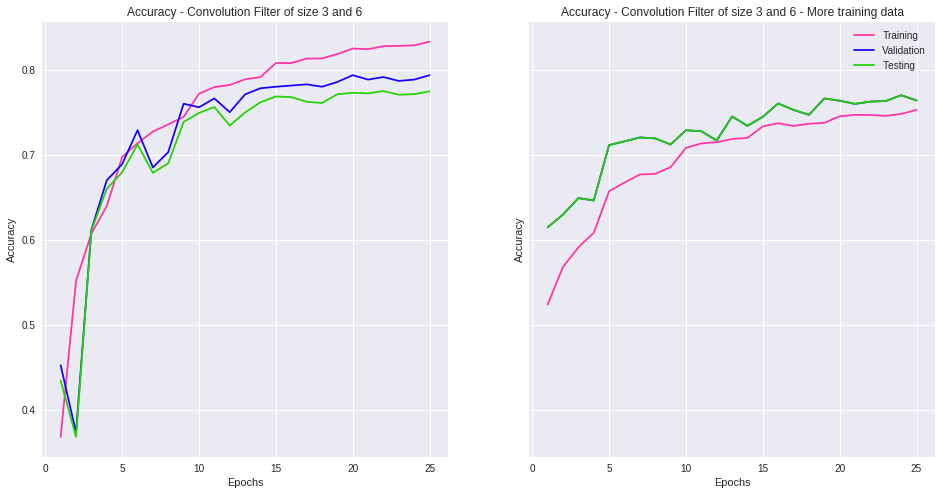

In [0]:
history_1i_original = pd.read_csv("history_1i_original.csv")
history_1i = pd.read_csv("history_1i.csv")

_, axes_loss = plt.subplots(1, 2, sharey=True, figsize=(16, 8))
_, axes_acc = plt.subplots(1, 2, sharey=True, figsize=(16, 8))

axes_loss[0].set_ylabel("Loss")
axes_loss[0].plot(range(1, 26), history_1i_original['loss'], '#ff33a3', label = "Training")
axes_loss[0].plot(range(1, 26), history_1i_original['val_loss'], '#1300FF', label = "Validation")
axes_loss[0].plot(range(1, 26), history_1i_original['test_loss'], '#23D300', label = "Testing")
axes_loss[0].grid(True)
axes_loss[0].set_title("Loss- Convolution Filter of size 3 and 6")
axes_loss[0].set_xlabel("Epochs")

axes_loss[1].set_ylabel("Loss")
axes_loss[1].plot(range(1, 26), history_1i['loss'], '#ff33a3', label = "Training")
axes_loss[1].plot(range(1, 26), history_1i['val_loss'], '#1300FF', label = "Validation")
axes_loss[1].plot(range(1, 26), history_1i['test_loss'], '#23D300', label = "Testing")
axes_loss[1].grid(True)
axes_loss[1].set_title("Loss- Convolution Filter of size 3 and 6 - More training data")
axes_loss[1].set_xlabel("Epochs")


axes_acc[0].set_ylabel("Accuracy")
axes_acc[0].plot(range(1, 26), history_1i_original['acc'], '#ff33a3', label = "Training")
axes_acc[0].plot(range(1, 26), history_1i_original['val_acc'], '#1300FF', label = "Validation")
axes_acc[0].plot(range(1, 26), history_1i_original['test_acc'], '#23D300', label = "Testing")
axes_acc[0].grid(True)
axes_acc[0].set_title("Accuracy - Convolution Filter of size 3 and 6")
axes_acc[0].set_xlabel("Epochs")

axes_acc[1].set_ylabel("Accuracy")
axes_acc[1].plot(range(1, 26), history_1i['acc'], '#ff33a3', label = "Training")
axes_acc[1].plot(range(1, 26), history_1i['val_acc'], '#1300FF', label = "Validation")
axes_acc[1].plot(range(1, 26), history_1i['test_acc'], '#23D300', label = "Testing")
axes_acc[1].grid(True)
axes_acc[1].set_title("Accuracy - Convolution Filter of size 3 and 6 - More training data")
axes_acc[1].set_xlabel("Epochs")
    
axes_acc[-1].legend()
plt.show()

In [0]:
files.download('history_1i.csv') # from colab to browser download
files.download('history_1i_original.csv') # from colab to browser download

Aplicando esta técnica se aumenta la data de entrenamiento, es recomendable cuando no se cuenta con data suficiente para cierto problemas de la vida real. Por esto se aplican cambios en la data existente como rotaciones, cambios de tamaños entre otras operaciones.
No hay cambio de datos porque las redes neuronales convolucionales tienen la propiedad de invarianza a todos estos cambios, por ejemplo si una imagen es de un perro al sufrir todas esta modificaciones conservara su etiqueta porque las CNN aprenden a extraer caracteristicas, sin importa el tamaño de la imagen, la iluminación ó la rotación.

El modelo es bueno, pero no lo es tanto comparado con uno de los mejores modelos entreanados hasta este punto. Entrenar un modelo con suficiente data no debería nececitar este procedimiento porque conduce a sobreajustar el modelo.



---



## Pregunta J

> Para una comparación del desempeño de la red neuronal, pre-procese el dataset de CIFAR-10 y calcule los descriptores manuales SIFT, para un mejor entendimiento de éstos consulte:  https://ianlondon.github.io/blog/how-to-sift-opencv/ y https://docs.opencv.org/3.4.3/da/df5/tutorial_py_sift_intro.html. Como se genera un descriptor de 128 dimensiones para cada *keypoint* comprima esta información de alguna manera, comente sobre la operación.

El calculo de descriptores son importantes en el ámbito del reconocimiento de imágenes se buscan características que no sean sensibles a los cambios en la resolución de la imagen, rotación o escala. El algoritmo **Scale Invariant Feature Transform** (SIFT) se encarga de solucionar todo esto.
A continuación se realiza el cálculo de los descriptores, y se comprime la información en 128 dimensiones para cada keypoint.

In [0]:
def pre_process(img):
    if np.max(img) <= 1:
        img*=255
    img = img.astype("uint8")
    img_gray= cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return img_gray

def calculate_sift(cifar):
    sift_cifar = []
    for image in cifar:
      img_gray = pre_process(image)
      sift = cv2.xfeatures2d.SIFT_create()
      kp, desc = sift.detectAndCompute(img_gray, None)
      if type(desc) == type(None):
        desc = np.zeros((1,128))
      compress_desc = np.mean(desc,axis=0) #compress all keypoints
      sift_cifar.append(compress_desc)
    return np.asarray(sift_cifar)

In [0]:
cx_train = calculate_sift(x_train)
cx_val= calculate_sift(x_val)
cx_test = calculate_sift(x_test)

In [0]:
cx_train.shape

(45000, 128)

### Item J1
>  Visualice los *keypoint* para una mejor comprensión visual de lo que son los descriptores manuales en alguna imagen aleatoria.



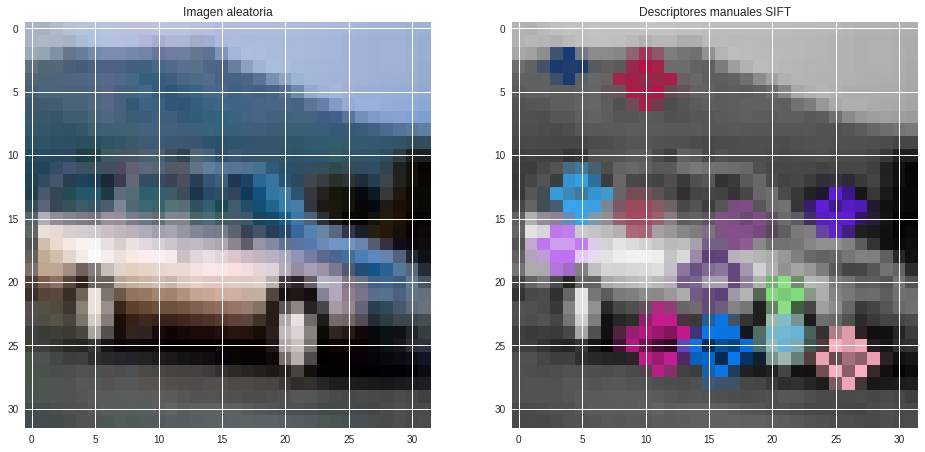

In [0]:
img = x_train[4]
img = img.astype("uint8")
img_gray= cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
sift = cv2.xfeatures2d.SIFT_create()
kp = sift.detect(img_gray,None)
img_sift =cv2.drawKeypoints(img_gray,kp, None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(16, 10))
plt.subplot(1,2,2)
plt.title('Descriptores manuales SIFT')
plt.imshow(img_sift)
plt.subplot(1,2,1)
plt.title('Imagen aleatoria')
plt.imshow(img)
plt.show()


> Entrene una red neuronal densa (la misma que sigue a las capas convoluciones definidas en los modelos previos), compare el desempeño de la red con el modelo más básico (o de peor desempeño) y el modelo de mejor desempeño obtenido hasta este punto. Comente sobre el entrenamiento (error y tiempos de ejecución) y resultados.

In [0]:
#Estandarizando
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(cx_train)

cx_train_st = scaler.transform(cx_train)
cx_val_st = scaler.transform(cx_val)
cx_test_st = scaler.transform(cx_test)

In [0]:
modelj = keras.models.Sequential()
modelj.add(keras.layers.Dense(512, input_dim = cx_train.shape[1]))
modelj.add(keras.layers.Activation('relu'))
modelj.add(keras.layers.Dense(10))
modelj.add(keras.layers.Activation('softmax'))

opt = keras.optimizers.SGD(lr=0.01)
modelj.compile(optimizer = opt, loss='categorical_crossentropy', metrics=['accuracy'])
modelj.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 512)               66048     
_________________________________________________________________
activation_11 (Activation)   (None, 512)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 10)                5130      
_________________________________________________________________
activation_12 (Activation)   (None, 10)                0         
Total params: 71,178
Trainable params: 71,178
Non-trainable params: 0
_________________________________________________________________


In [0]:
test_loss = []
test_acc = []
lrate = keras.callbacks.LearningRateScheduler(step_decay)
historyj = modelj.fit(cx_train,
                      y_train,
                      batch_size = 32,
                      epochs = 100,
                      verbose = 1,
                      validation_data = (cx_val, y_val), shuffle=True, callbacks=[TestCallback((cx_test, y_test)), lrate])
historyj.history["test_loss"] = test_loss
historyj.history["test_acc"] = test_acc
result= pd.DataFrame(historyj.history)
result.to_csv("history_1j.csv")

Train on 45000 samples, validate on 5000 samples
Epoch 1/100
45000/45000 [==============================] - 7s 148us/step - loss: 5.3477 - acc: 0.1879 - val_loss: 2.1754 - val_acc: 0.2336

Testing loss: 2.187779480743408, acc: 0.2341

Epoch 2/100
45000/45000 [==============================] - 6s 136us/step - loss: 2.1119 - acc: 0.2506 - val_loss: 2.0897 - val_acc: 0.2532

Testing loss: 2.096605550003052, acc: 0.2571

Epoch 3/100
45000/45000 [==============================] - 6s 137us/step - loss: 2.0492 - acc: 0.2674 - val_loss: 2.0368 - val_acc: 0.2784

Testing loss: 2.0488065757751466, acc: 0.2762

Epoch 4/100
45000/45000 [==============================] - 6s 137us/step - loss: 2.0154 - acc: 0.2780 - val_loss: 2.0212 - val_acc: 0.2812

Testing loss: 2.038731485748291, acc: 0.2774

Epoch 5/100
45000/45000 [==============================] - 6s 137us/step - loss: 1.9848 - acc: 0.2915 - val_loss: 2.0052 - val_acc: 0.2944

Testing loss: 2.0180160228729247, acc: 0.2866

Epoch 6/100
45000/4

KeyboardInterrupt: ignored

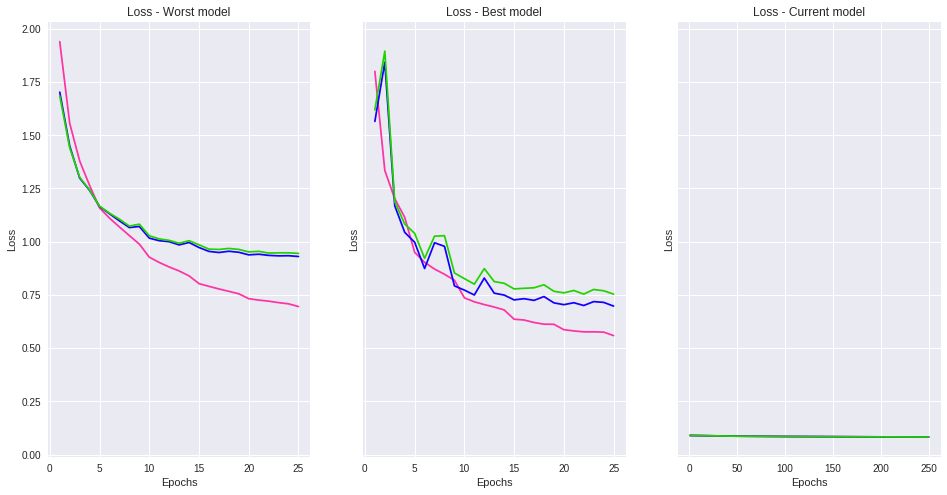

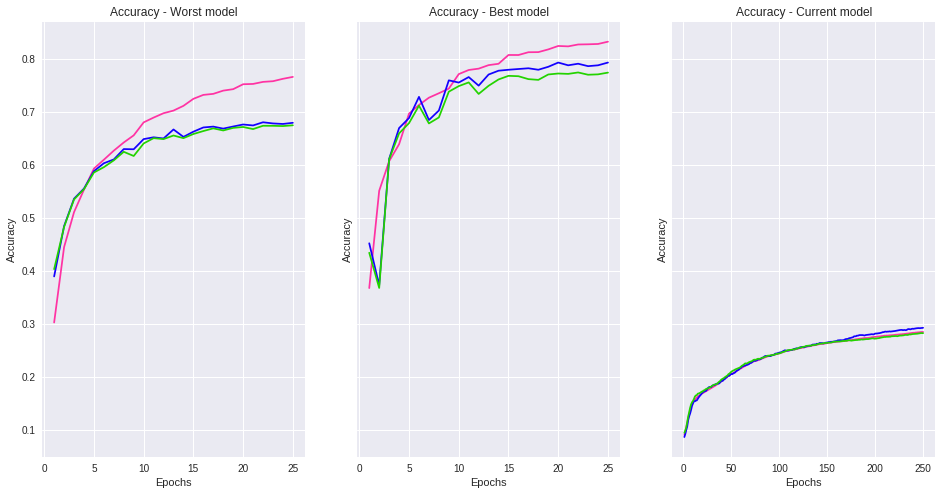

In [0]:
histories = [pd.read_csv("history_1d.csv"), pd.read_csv("history_1i_original.csv"), pd.read_csv("history_1j.csv")]

_, axes_loss = plt.subplots(1, 3, sharey=True, figsize=(16, 8))
_, axes_acc = plt.subplots(1, 3, sharey=True, figsize=(16, 8))
labels = ["Worst", "Best", "Current"]
epochs = [25, 25, 250]

for i in range(3):
    history = histories[i]
    axes_loss[i].set_ylabel("Loss")
    axes_loss[i].plot(range(1, epochs[i]+1), history['loss'], '#ff33a3', label = "Training")
    axes_loss[i].plot(range(1, epochs[i]+1), history['val_loss'], '#1300FF', label = "Validation")
    axes_loss[i].plot(range(1, epochs[i]+1), history['test_loss'], '#23D300', label = "Testing")
    axes_loss[i].grid(True)
    axes_loss[i].set_title("Loss - "+labels[i]+" model")
    axes_loss[i].set_xlabel("Epochs")
    
    axes_acc[i].set_ylabel("Accuracy")
    axes_acc[i].plot(range(1, epochs[i]+1), history['acc'], '#ff33a3', label = "Training")
    axes_acc[i].plot(range(1, epochs[i]+1), history['val_acc'], '#1300FF', label = "Validation")
    axes_acc[i].plot(range(1, epochs[i]+1), history['test_acc'], '#23D300', label = "Testing")
    axes_acc[i].grid(True)
    axes_acc[i].set_title("Accuracy - "+labels[i]+" model")
    axes_acc[i].set_xlabel("Epochs")
    
plt.show()

En resumen usar los descriptores reduce drasticamente el tiempo de entrenamiento de la red. Realizando un trabajo similar a lo que realizan las capas convolcionales pero guardando caracteristicas relevantes de los descriptores.

In [0]:
files.download("history_1j.csv")



---
## Pregunta K



>  Elija una de las redes entrenadas en esta sección (preferentemente una con buen desempeño) y determine los pares de objetos (por ejemplo “camiones” con “autos”) que la red tiende a confundir. Conjeture el motivo de tal confusión.

Primero, definimos el modelo con el cual vamos a trabajar, y realizamos el entrenamiento:

In [0]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, (3, 3), padding='same', input_shape = x_train.shape[1:], kernel_regularizer = keras.regularizers.l2(0.005)))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer = keras.regularizers.l2(0.0013)))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Conv2D(128, (6, 6), padding='same', kernel_regularizer = keras.regularizers.l2(0.005)))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Conv2D(128, (6, 6), padding='same', kernel_regularizer = keras.regularizers.l2(0.0013)))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dense(10))
model.add(keras.layers.Activation('softmax'))

opt = keras.optimizers.rmsprop(lr=0.001, decay=1e-6)
model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
test_loss = []
test_acc = []
lrate = keras.callbacks.LearningRateScheduler(step_decay)
history_1i = model.fit(x_train, y_train, batch_size= 128, epochs = 15, validation_data = (x_val, y_val), shuffle=True, callbacks=[TestCallback((x_test, y_test)), lrate])
history_1i.history["test_loss"] = test_loss
history_1i.history["test_acc"] = test_acc
result = pd.DataFrame(history_1i.history)
result.to_csv("history_1k.csv")
model.save("model_1k.h5")

Train on 45000 samples, validate on 5000 samples
Epoch 1/15
45000/45000 [==============================] - 29s 637us/step - loss: 0.8115 - acc: 0.7650 - val_loss: 0.9329 - val_acc: 0.7258

Testing loss: 0.9773874426841735, acc: 0.712

Epoch 2/15
45000/45000 [==============================] - 29s 636us/step - loss: 0.7611 - acc: 0.7872 - val_loss: 0.8980 - val_acc: 0.7522

Testing loss: 0.9316903594017029, acc: 0.7393

Epoch 3/15
45000/45000 [==============================] - 29s 635us/step - loss: 0.7193 - acc: 0.8031 - val_loss: 0.9391 - val_acc: 0.7442

Testing loss: 0.983377969455719, acc: 0.7319

Epoch 4/15
45000/45000 [==============================] - 29s 636us/step - loss: 0.6745 - acc: 0.8182 - val_loss: 1.2654 - val_acc: 0.6686

Testing loss: 1.3068764961242676, acc: 0.6575

Epoch 5/15
45000/45000 [==============================] - 29s 635us/step - loss: 0.5085 - acc: 0.8768 - val_loss: 0.8248 - val_acc: 0.7898

Testing loss: 0.8768826247215271, acc: 0.7724

Epoch 6/15
45000/4

Importamos las líbrerias necesarias para realizar la matriz de confusión:

In [0]:
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [0]:
model_loaded = keras.models.load_model("model_1k.h5")
y_pred = np.argmax(model_loaded.predict(x_test), axis = 1)
y_test_original = np.argmax(y_test, axis = 1)
cnf_matrix = confusion_matrix(y_test_original, y_pred)

Confusion matrix, without normalization
[[807  14  22  20  11  14  12   9  58  33]
 [  8 905   5   6   3   3   9   1  19  41]
 [ 58   5 662  54  69  52  64  23   9   4]
 [ 18   8  46 587  47 172  62  35  10  15]
 [ 13   6  50  46 750  41  35  49   8   2]
 [  9   3  30 147  38 688  31  39   7   8]
 [  2   3  34  44  29  26 852   4   4   2]
 [  8   2  21  30  32  47   7 846   2   5]
 [ 45  31  10  10   3   8   6   6 862  19]
 [ 19  78   9  10   2   6  10  14  22 830]]


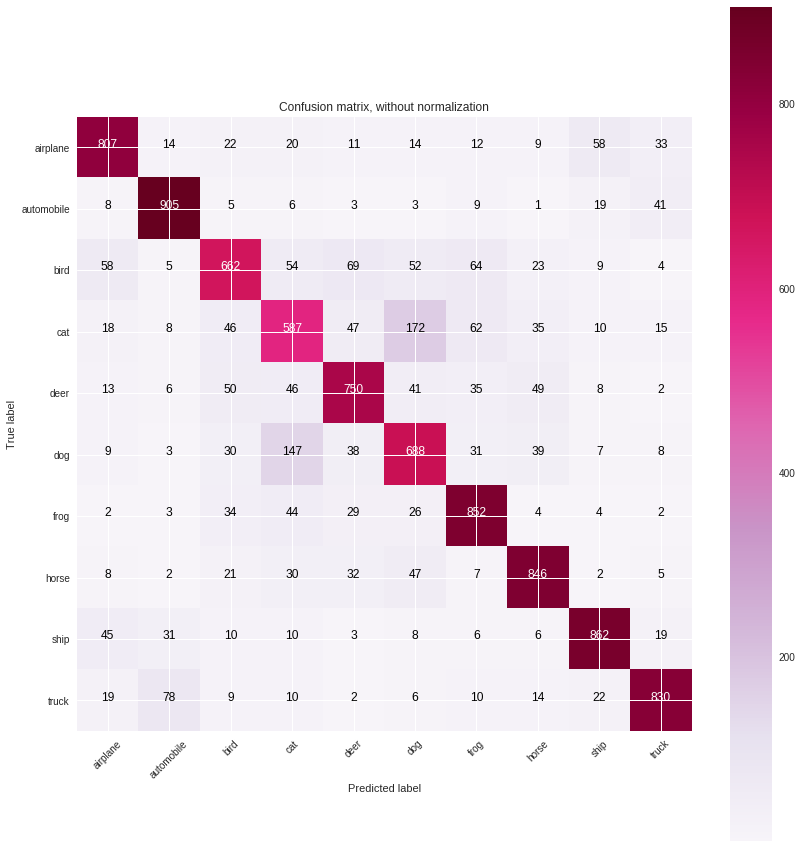

In [0]:
np.set_printoptions(precision=2)
plt.figure(figsize=(12,12))
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plot_confusion_matrix(cnf_matrix, classes = class_names, title='Confusion matrix, without normalization', cmap = "PuRd")
plt.show()

Normalized confusion matrix
[[0.81 0.01 0.02 0.02 0.01 0.01 0.01 0.01 0.06 0.03]
 [0.01 0.91 0.01 0.01 0.   0.   0.01 0.   0.02 0.04]
 [0.06 0.01 0.66 0.05 0.07 0.05 0.06 0.02 0.01 0.  ]
 [0.02 0.01 0.05 0.59 0.05 0.17 0.06 0.04 0.01 0.01]
 [0.01 0.01 0.05 0.05 0.75 0.04 0.04 0.05 0.01 0.  ]
 [0.01 0.   0.03 0.15 0.04 0.69 0.03 0.04 0.01 0.01]
 [0.   0.   0.03 0.04 0.03 0.03 0.85 0.   0.   0.  ]
 [0.01 0.   0.02 0.03 0.03 0.05 0.01 0.85 0.   0.01]
 [0.04 0.03 0.01 0.01 0.   0.01 0.01 0.01 0.86 0.02]
 [0.02 0.08 0.01 0.01 0.   0.01 0.01 0.01 0.02 0.83]]


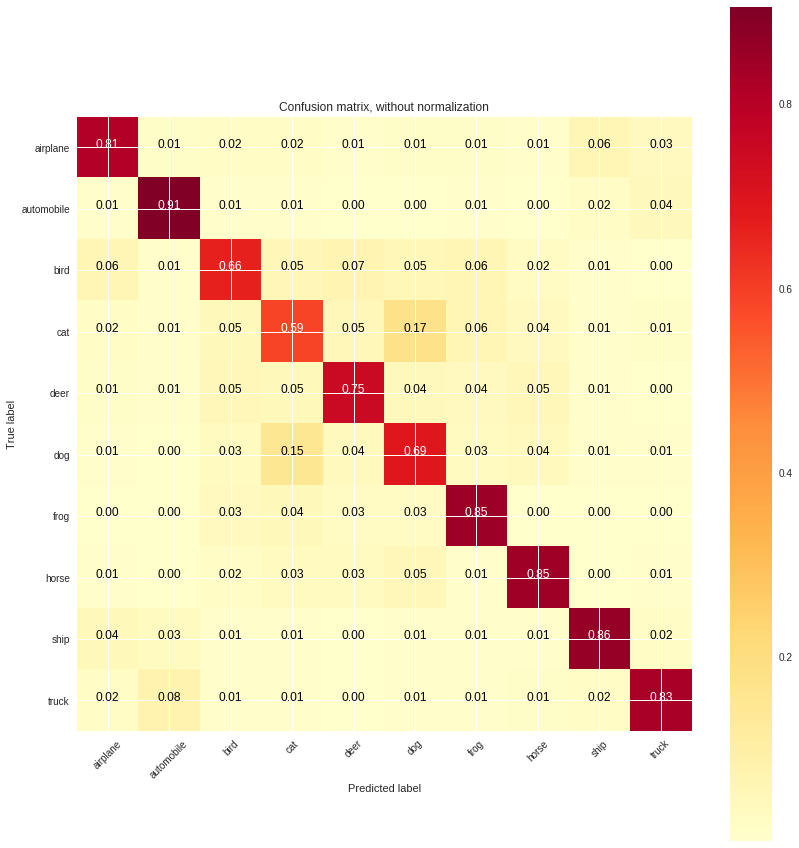

In [0]:
plt.figure(figsize=(12,12))
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plot_confusion_matrix(cnf_matrix, classes = class_names, normalize = True, title='Confusion matrix, without normalization', cmap = "YlOrRd")
plt.show()

Se puede apreciar que aquellos que más son confundidos por el modelo son el perro y el gato. Esto, se debe a que las caracteristicaas aprendidas para cada una de las clases son muy similares lo que hace dificil para el algoritmo elegir correctamente todos los casos.



---


## Pregunta L
> Elija una de las redes entrenadas (preferentemente una con buen desempeño) y visualice los pesos correspondientes a los filtros de la primera capa convolucional. Visualice además el efecto del filtro sobre algunas imágenes de entrenamiento. Repita el proceso para los pesos de la última capa convolucional; Comente y compare con los descriptores SIFT.



Vamos a visualizar  los filtros de un modelo entrenado, para que podamos entender el comportamiento de esos filtros. Por ejemplo, el primer filtro de la primera capa del modelo entrenado en g) se ve así:

In [0]:
nc1, nc2 = (3, 6)

conv1 = keras.layers.Conv2D(64, (nc1, nc1), padding='same', input_shape = x_train.shape[1:], kernel_regularizer = keras.regularizers.l2(0.005))
activ1 = keras.layers.Activation('relu')
conv2 = keras.layers.Conv2D(64, (nc1, nc1), padding='same', kernel_regularizer = keras.regularizers.l2(0.0013))
activ2 = keras.layers.Activation('relu')
pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))
drop1 = keras.layers.Dropout(0.4)
conv3 = keras.layers.Conv2D(128, (nc2, nc2), padding='same', kernel_regularizer = keras.regularizers.l2(0.005))
activ3 = keras.layers.Activation('relu')
conv4 = keras.layers.Conv2D(128, (nc2, nc2), padding='same', kernel_regularizer = keras.regularizers.l2(0.0013))
activ4 = keras.layers.Activation('relu')
pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))
drop2 = keras.layers.Dropout(0.1)

model = keras.models.Sequential()
model.add(conv1)
model.add(activ1)
model.add(conv2)
model.add(activ2)
model.add(pool1)
model.add(drop1)
model.add(conv3)
model.add(activ3)
model.add(conv4)
model.add(activ4)
model.add(pool2)
model.add(drop2)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dense(10))
model.add(keras.layers.Activation('softmax'))
model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=['accuracy'])

lrate = keras.callbacks.LearningRateScheduler(step_decay)
test_loss = []
test_acc = []
history = model.fit(x_train, y_train, batch_size= 32, epochs = 15, validation_data=(x_val, y_val), shuffle=True, callbacks=[TestCallback((x_test, y_test)), lrate]).history
history["test_loss"] = test_loss
history["test_acc"] = test_acc

result = pd.DataFrame(history)
result.to_csv("history_1L.csv")
model.save("model_1L.h5")

Train on 45000 samples, validate on 5000 samples
Epoch 1/15
45000/45000 [==============================] - 53s 1ms/step - loss: 1.7774 - acc: 0.3724 - val_loss: 1.3476 - val_acc: 0.5294

Testing loss: 1.3708392274856567, acc: 0.5176

Epoch 2/15
45000/45000 [==============================] - 52s 1ms/step - loss: 1.3613 - acc: 0.5396 - val_loss: 1.4304 - val_acc: 0.5094

Testing loss: 1.4832660413742065, acc: 0.5025

Epoch 3/15
45000/45000 [==============================] - 50s 1ms/step - loss: 1.2127 - acc: 0.6016 - val_loss: 1.2164 - val_acc: 0.6004

Testing loss: 1.2732210643768311, acc: 0.5872

Epoch 4/15
45000/45000 [==============================] - 51s 1ms/step - loss: 1.1317 - acc: 0.6347 - val_loss: 1.2388 - val_acc: 0.5968

Testing loss: 1.293462092781067, acc: 0.5816

Epoch 5/15
45000/45000 [==============================] - 51s 1ms/step - loss: 0.9660 - acc: 0.6922 - val_loss: 0.8935 - val_acc: 0.7198

Testing loss: 0.9316169027328491, acc: 0.7013

Epoch 6/15
45000/45000 [===

A continuación se muestran los pesos de la capa de entrada:

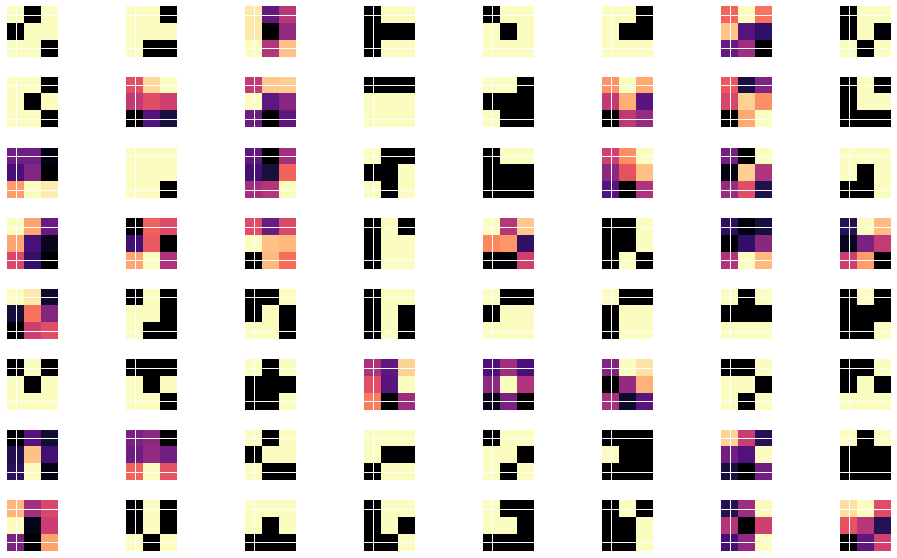

In [0]:
x1w = conv1.get_weights()[0][:,:,0,:]
_, ax = plt.subplots(8, 8, figsize=(15, 9))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(x1w[:,:,i+j*8], interpolation="nearest",cmap="magma")
        ax[i, j].set_yticklabels([])
        ax[i, j].set_xticklabels([])

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.4, wspace=0.4)
plt.show()

Ahora vamos a visualizar los pesos de la última capa convolucional.

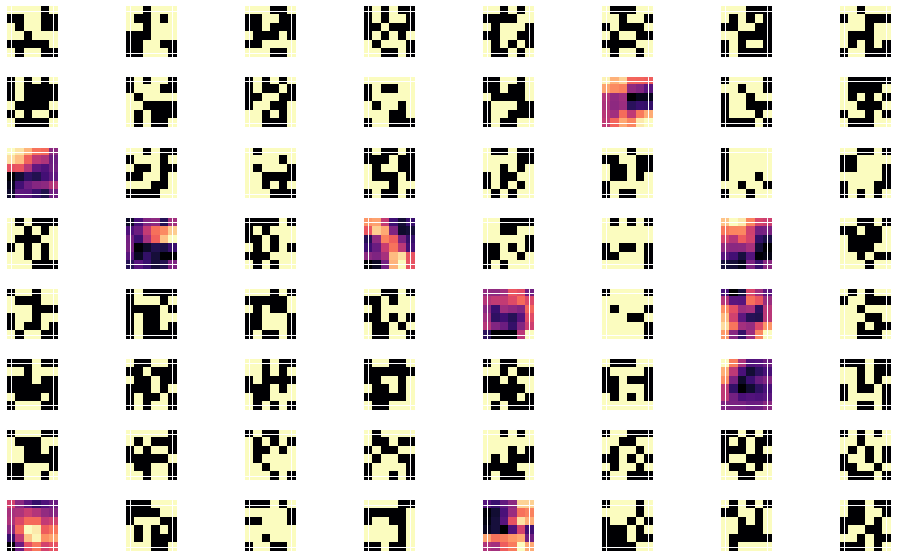

In [0]:
x1w = conv4.get_weights()[0][:,:,0,:]
_, ax = plt.subplots(8, 8, figsize=(15, 9))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(x1w[:,:,i+j*8], interpolation="nearest",cmap="magma")
        ax[i, j].set_yticklabels([])
        ax[i, j].set_xticklabels([])

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.4, wspace=0.4)
plt.show()

In [0]:
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(col_size*2.5,row_size*2.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='magma')
            ax[row][col].set_yticklabels([])
            ax[row][col].set_xticklabels([])
            ax[row][col].grid(False)
            activation_index += 1
               
    plt.show()

In [0]:
layer_outputs = [layer.output for layer in model.layers]
activation_model = keras.models.Model(inputs = model.input, outputs = layer_outputs)
activations = activation_model.predict(x_train[19].reshape(1,32,32,3))

In [0]:
layer_weights = np.array([layer.get_weights() for layer in model.layers])
np.save("layers_1L", layer_weights)

In [0]:
files.download("layers_1L.npy")

In [0]:
loaded_layers = np.load("layers_1L.npy")

Con esta imagen vamos a trabajar, se la entregaremos como entrada a la red y visualizaremos los filtros.

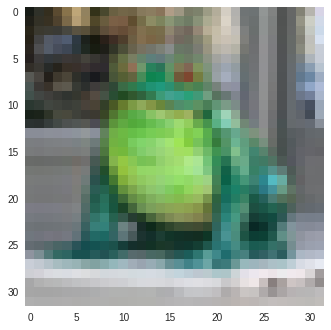

In [0]:
plt.imshow(x_train[19])
plt.grid(False)
plt.show()

Descripción de las capas del modelo con párametros para entrenar.

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_33 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_34 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 128)       295040    
__________


En general, observamos que los filtros de bajo nivel funcionan como detectores de borde y extraen caracteristicas gruesas como formas y contornos, y a medida que avanzamos en las capas, tienden a capturar caracteristicas mas finas, para esto vamos a visualizar la primera capa convolucional de nuestro modelo.

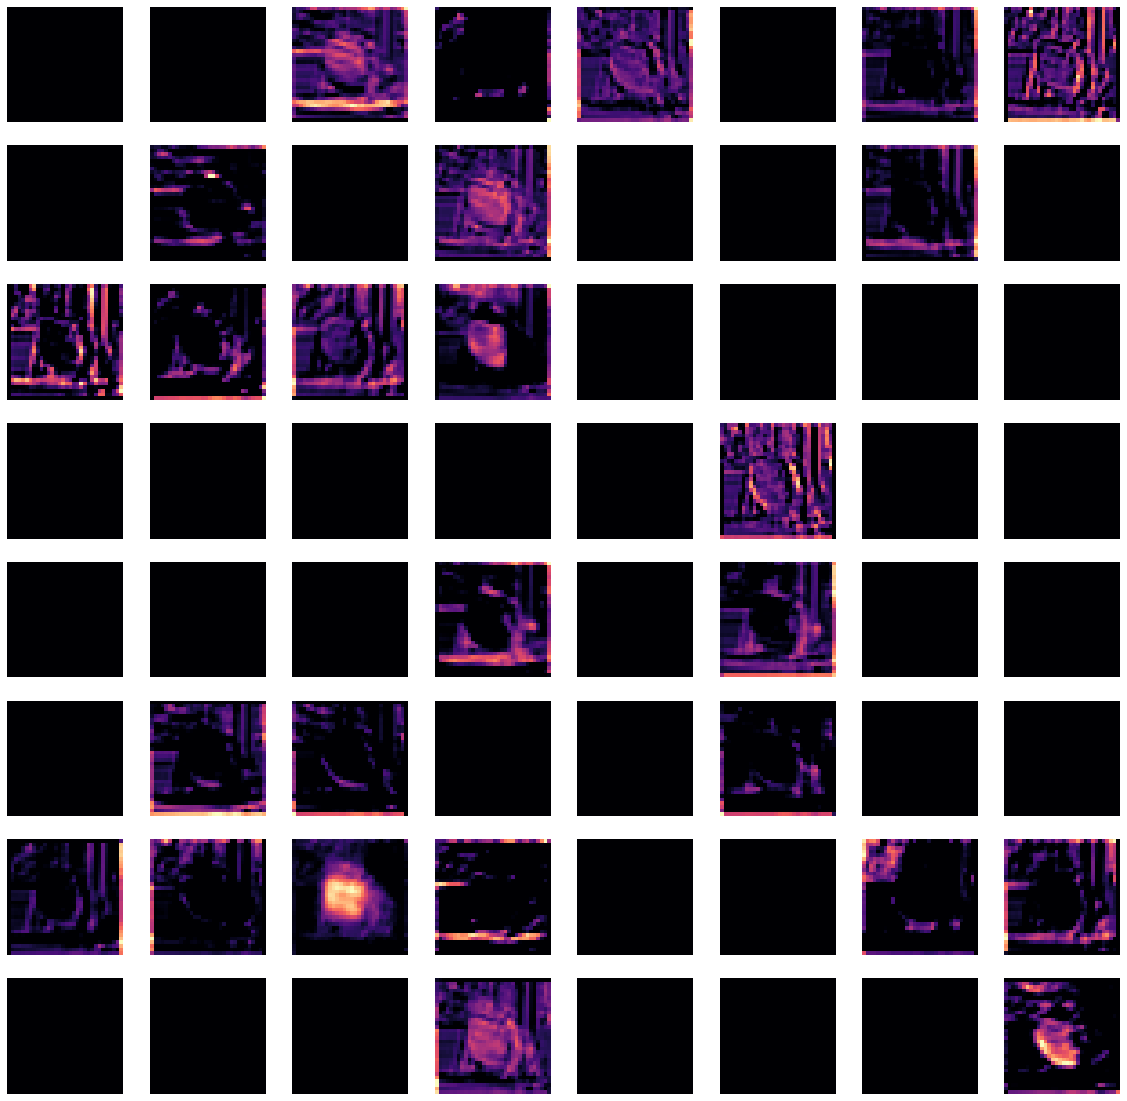

In [0]:
display_activation(activations, 8, 8, 1)

Ultima capa convolucional:

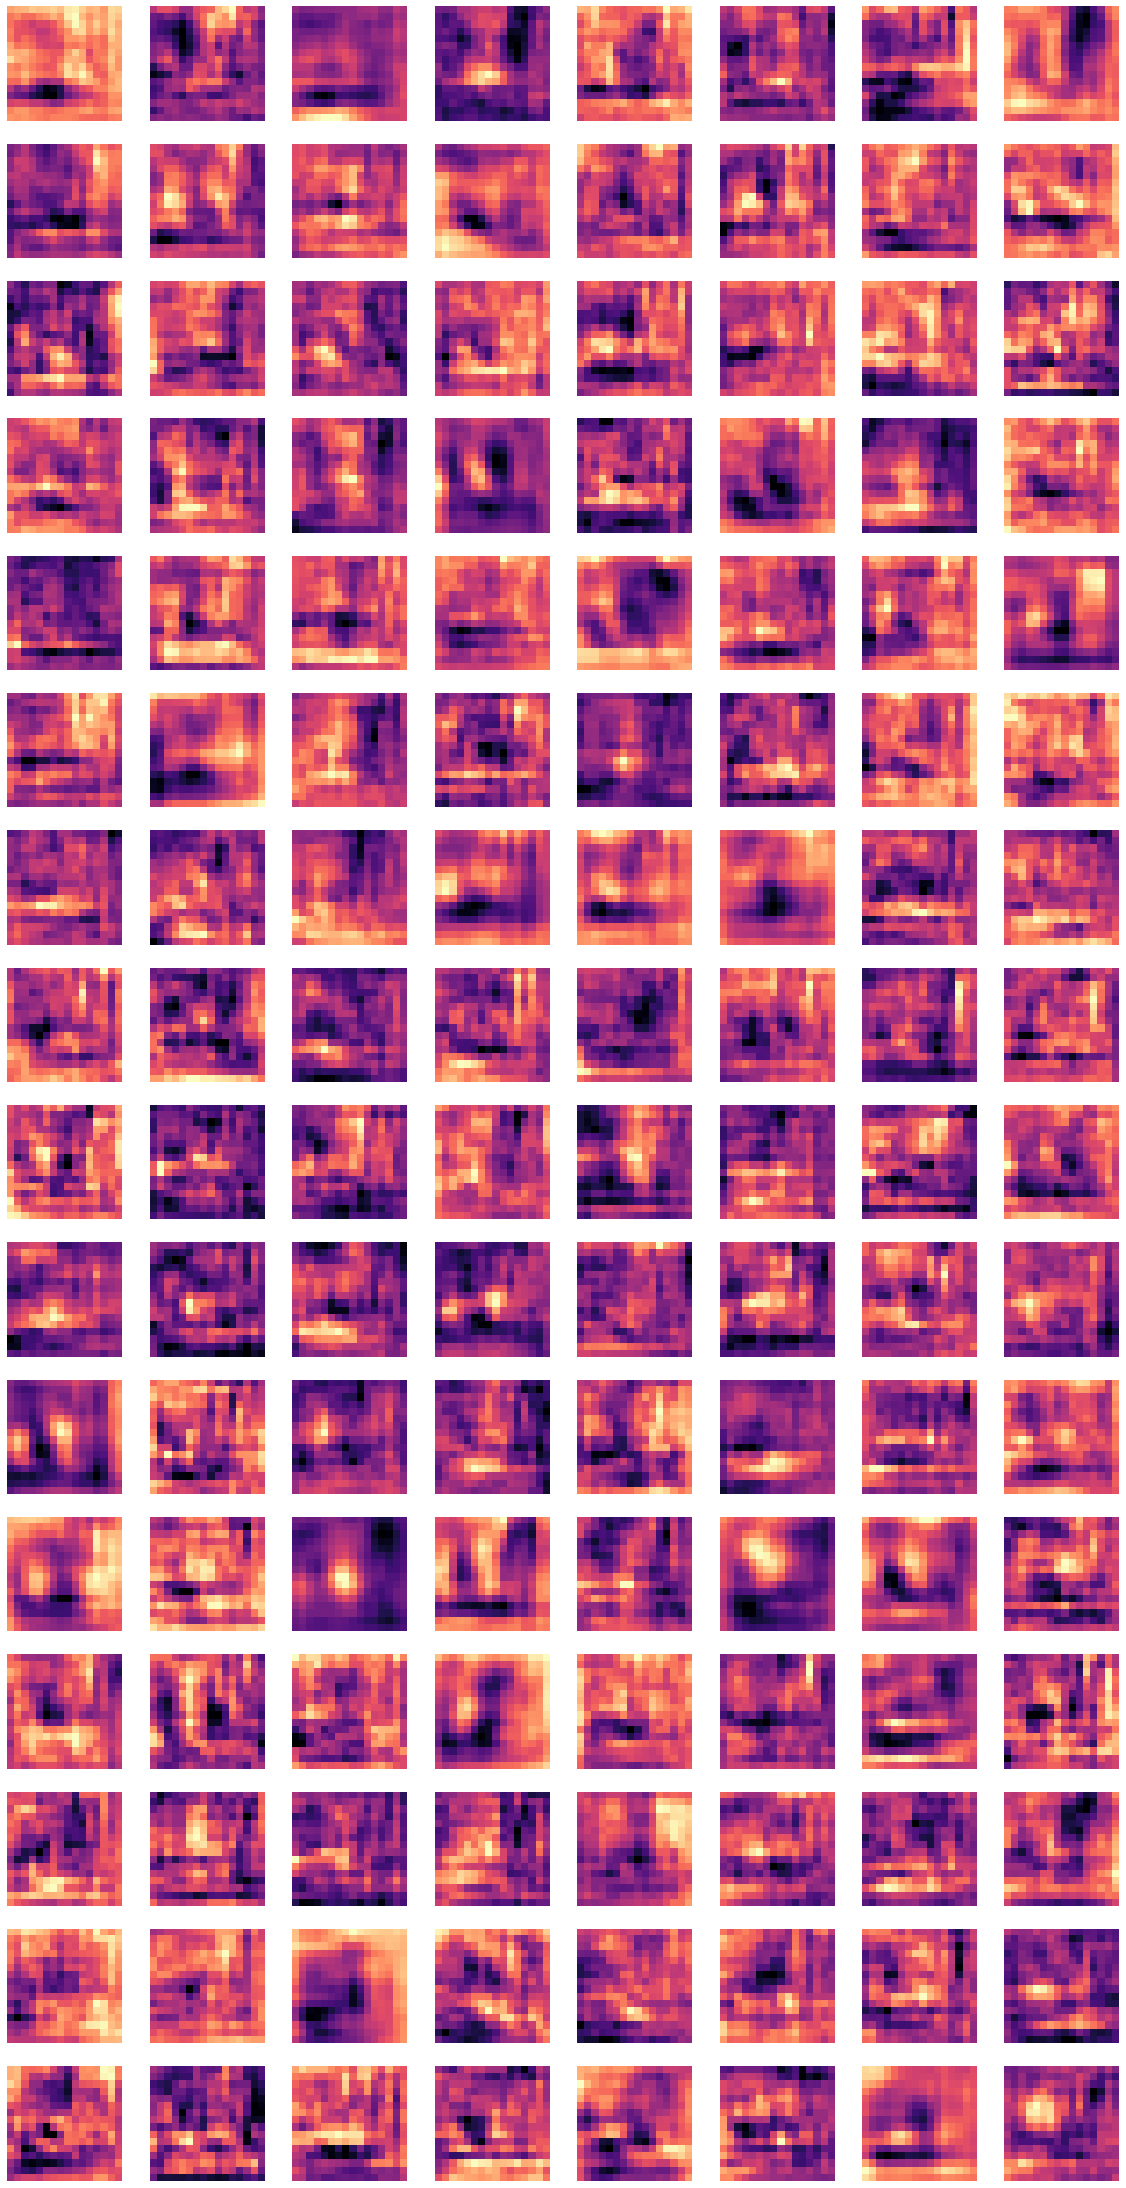

In [0]:
display_activation(activations, 8, 16, 8)

Los SIFT son relevantes para tareas de identificación, muy utilizados en tareas de visión por computador incluso en aplicaciones en tiempo real. En cambio las redes convolucionales son relevantes para tareas para tareas de categorización y clasificación.

Usar el algoritmo SIFT hace a las redes mas simples y con menos parámetros en comparación con la CNN, lo que las hace mas rapidas con un conjunto de entrenamiento mas pequeño. Las CNNs requieren alta demanda de procesamiento de datos, entre mas datos se tengan es mejor.